In [1]:
import GPy
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from numpy.linalg import inv
sys.path.insert(1, '/Users/dananjayaliyanage/git/emulator-validation/src')
from configurations import load_design, transform_design
from bayes_mcmc import *
from emulator import *
from calculations_load import trimmed_model_data
from bins_and_cuts import *
import matplotlib.patches as mpatches
from bayes_exp import Y_exp_data
from sklearn.preprocessing import StandardScaler


Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]', '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]', '$(\\eta/s)_{\\mathrm{kink}}$', '$(\\zeta/s)_{\\max}$', '$T_{\\zeta,c}$ [GeV]', '$w_{\\zeta}$ [GeV]', '$\\lambda_{\\zeta}$', '$b_{\\pi}$', '$T_{\\mathrm{sw}}$ [GeV]'], 'ma

 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:Trying to unpickle estima

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 5000;

<IPython.core.display.Javascript object>

In [3]:
# Put all model parametr names to an array
model_labels= ['N','p',r'$\sigma_k$','w',r'$d_{min}^3$',r'$\tau_R$',r'$\alpha$',r'$b_{\pi}$',r'$T_{sw}$']
viscous_eta=[r'$\eta \,$ at T={} GeV'.format(round(i,2)) for i in np.linspace(0.135,0.4,10)]
viscous_bulk=[r'$\zeta \,$ at T={} GeV'.format(round(i,2)) for i in np.linspace(0.135,0.4,10)]
all_model_labels=model_labels+viscous_eta+viscous_bulk

In [4]:
all_model_labels

['N',
 'p',
 '$\\sigma_k$',
 'w',
 '$d_{min}^3$',
 '$\\tau_R$',
 '$\\alpha$',
 '$b_{\\pi}$',
 '$T_{sw}$',
 '$\\eta \\,$ at T=0.14 GeV',
 '$\\eta \\,$ at T=0.16 GeV',
 '$\\eta \\,$ at T=0.19 GeV',
 '$\\eta \\,$ at T=0.22 GeV',
 '$\\eta \\,$ at T=0.25 GeV',
 '$\\eta \\,$ at T=0.28 GeV',
 '$\\eta \\,$ at T=0.31 GeV',
 '$\\eta \\,$ at T=0.34 GeV',
 '$\\eta \\,$ at T=0.37 GeV',
 '$\\eta \\,$ at T=0.4 GeV',
 '$\\zeta \\,$ at T=0.14 GeV',
 '$\\zeta \\,$ at T=0.16 GeV',
 '$\\zeta \\,$ at T=0.19 GeV',
 '$\\zeta \\,$ at T=0.22 GeV',
 '$\\zeta \\,$ at T=0.25 GeV',
 '$\\zeta \\,$ at T=0.28 GeV',
 '$\\zeta \\,$ at T=0.31 GeV',
 '$\\zeta \\,$ at T=0.34 GeV',
 '$\\zeta \\,$ at T=0.37 GeV',
 '$\\zeta \\,$ at T=0.4 GeV']

In [5]:
MAP_params = {'Pb-Pb-2760': [14.128, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136],
              'Au-Au-200' : [5.821, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136]
                }

In [6]:
map_values=np.array(MAP_params["Pb-Pb-2760"])

In [7]:
MAP=transform_design(map_values.reshape(1,-1))

In [8]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [9]:
em=Trained_Emulators['Pb-Pb-2760']

In [10]:
# Get all the observables list
nobs=0
observables=[]
for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [11]:
# Get the simulation results corresponding to design points

SS=StandardScaler(copy=False)
Y=[]
for ipt, data in enumerate(trimmed_model_data['Pb-Pb-2760']):
    row = np.array([])
    for obs in observables:
        values = np.array(data[idf][obs]['mean'])
        if np.isnan(values).sum() > 0:
            print("WARNING! FOUND NAN IN MODEL DATA WHILE BUILDING EMULATOR!")
            print("Design pt = " + str(pt) + "; Obs = " + obs)
        row = np.append(row, values)
    Y.append(row)
Y = np.array(Y)
print("Y_Obs shape[Ndesign, Nobs] = " + str(Y.shape))
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z=pca.fit_transform(SS.fit_transform(Y))[:,:10]

Y_Obs shape[Ndesign, Nobs] = (485, 123)


In [12]:
# Get design parametrs for which are already transformed model parameter
design, design_max, design_min, labels = prepare_emu_design('Pb-Pb-2760')

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 
Note : Transforming design of viscosities


In [13]:
if len(delete_design_pts_set) > 0:
    print("Warning! Deleting " + str(len(delete_design_pts_set)) + " points from data")
    design = np.delete(design, list(delete_design_pts_set), 0)

Warning! Deleting 15 points from data


In [14]:
em.gps[0].X_train_.shape

(485, 29)

In [15]:
boho=em.gps[0].y_train_.reshape(485,1)

In [16]:
boho[0:20]

array([[ 0.26841718],
       [ 0.06826242],
       [ 1.18692676],
       [ 0.41644668],
       [ 0.71570644],
       [-0.16002865],
       [ 0.68232638],
       [ 0.25163932],
       [-0.1168344 ],
       [ 1.08545563],
       [ 0.36866437],
       [-0.387509  ],
       [ 0.58868541],
       [ 0.67357912],
       [ 0.57073162],
       [ 0.06325995],
       [ 0.40788239],
       [-0.22504775],
       [-0.32983959],
       [ 0.05700586]])

In [17]:
em.gps[3].get_params()

{'alpha': 0.1,
 'copy_X_train': False,
 'kernel__k1': 1**2 * RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151]),
 'kernel__k2': WhiteKernel(noise_level=0.1),
 'kernel__k1__k1': 1**2,
 'kernel__k1__k2': RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151]),
 'kernel__k1__k1__constant_value': 1.0,
 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k1__k2__length_scale': array([9.98205   , 1.39641   , 1.69935   , 0.99873   , 4.90649   ,
        1.69607   , 0.59843   , 5.98973   , 0.03489   , 0.48579691,
        0.42717744, 0.36855797, 0.32421837, 0.37560888, 0.43243489,
        0.48926091, 0.54608692, 0.60291293, 0.65973894, 0.19400862,
        0.19587624,

In [18]:
em.gps[0].predict(em.gps[0].X_train_[1,:].reshape(1,29),return_cov=True)

(array([-0.18941622]), array([[0.01162498]]))

In [19]:
MAP.shape

(1, 29)

In [20]:


em.gps[0].X_train_[0,:]

array([ 1.58175400e+01, -6.76900000e-02,  9.81530000e-01,  9.27630000e-01,
        2.61235000e+00,  1.34389000e+00,  9.88000000e-03,  4.79271000e+00,
        1.47590000e-01,  1.30872280e-01,  1.22602219e-01,  1.14332158e-01,
        1.09059515e-01,  1.23575331e-01,  1.38091148e-01,  1.52606965e-01,
        1.67122781e-01,  1.81638598e-01,  1.96154415e-01,  1.00353612e-01,
        1.32742310e-01,  1.46156230e-01,  1.34890171e-01,  1.12014057e-01,
        8.78423474e-02,  6.76444520e-02,  5.22878733e-02,  4.09682001e-02,
        3.26413094e-02])

In [21]:
em.gps[6].kernel_.get_params()

{'k1': 2.75**2 * RBF(length_scale=[32.6, 2.21, 3.25, 1.76, 491, 2.09, 0.716, 25.2, 0.0649, 48.6, 42.7, 0.397, 32.4, 37.6, 43.2, 48.9, 2.21, 60.3, 66, 0.379, 0.839, 1.16, 19.8, 19.6, 19.3, 19, 17.8, 16.4, 2.82]),
 'k2': WhiteKernel(noise_level=0.01),
 'k1__k1': 2.75**2,
 'k1__k2': RBF(length_scale=[32.6, 2.21, 3.25, 1.76, 491, 2.09, 0.716, 25.2, 0.0649, 48.6, 42.7, 0.397, 32.4, 37.6, 43.2, 48.9, 2.21, 60.3, 66, 0.379, 0.839, 1.16, 19.8, 19.6, 19.3, 19, 17.8, 16.4, 2.82]),
 'k1__k1__constant_value': 7.5626595926800695,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': array([3.26155889e+01, 2.20795265e+00, 3.25229905e+00, 1.75596567e+00,
        4.90649000e+02, 2.08747365e+00, 7.16091301e-01, 2.52237037e+01,
        6.48795606e-02, 4.85796913e+01, 4.27177440e+01, 3.97209650e-01,
        3.24218373e+01, 3.75608883e+01, 4.32434894e+01, 4.89260905e+01,
        2.21255494e+00, 6.02912927e+01, 6.59738938e+01, 3.78561516e-01,
        8.38738537e-01, 1.16000753e+00, 

In [22]:
# a function that takes Scikit lern emulator as input and return the corresponding GPy emulator.
def convertToGPy(Scikit_emu):
    """Takes a scikitlearn gaussian emulator as input and conver it to a GPy gaussian emulator. This needs
    design space parameters and the corresponding pca observable (PCA 1, PCA 2 etc)"""
    dic=Scikit_emu.kernel_.get_params()
    kernel1= GPy.kern.RBF(input_dim=29, variance=dic['k1__k1__constant_value'], lengthscale=dic["k1__k2"].get_params()["length_scale"],ARD=True)
    #kernal2=GPy.kern.White(input_dim=29,variance=0.1)
    kernel=kernel1#+kernal2
    m = GPy.models.GPRegression(Scikit_emu.X_train_,Scikit_emu.y_train_.reshape(-1,1),kernel,noise_var=dic["k2__noise_level"])
    #m.constrain_positive('') 
    #m.optimize_restarts(num_restarts = 10)
    return m
    

In [23]:
#make an dictionary of GPy emulators corresponding to each of the 10 PCA components of the observables
GPy_emulators={}
for i in range(0,10):
    EM=em.gps[i]
    #zz=Z.T[i].reshape(-1,1)
    #print(zz.reshape(-1,))
    #print(em.gps[-i].y_train_)
    #print(zz-em.gps[i].y_train_)
    GPy_emulators[i]=convertToGPy(Scikit_emu=EM)

In [24]:
GPy_emulators[0].kern.param_array

array([1.47226967e+01, 2.88687065e+01, 3.02079097e+00, 5.97227624e+00,
       4.80807008e+00, 2.43159811e+02, 5.24663641e+00, 3.04496805e+01,
       5.04945563e+02, 2.24319632e-01, 4.85796913e+01, 4.27177440e+01,
       1.85347697e+00, 3.24218373e+01, 3.75608883e+01, 4.32434894e+01,
       1.27731953e+00, 5.46086916e+01, 6.02912927e+01, 6.59738938e+01,
       1.94008625e+01, 4.47652802e-01, 7.76220157e+00, 1.98467534e+01,
       1.98167564e+01, 1.92776110e+01, 8.98130699e+00, 1.77525507e+01,
       1.64284543e+01, 1.50849565e+01])

In [25]:
#MAP_ll=np.array([[i] for i in MAP])

In [26]:
GPy_emulators[0].kern

rbf.,value,constraints,priors
variance,14.722696711905735,+ve,
lengthscale,"(29,)",+ve,


In [27]:
#em.gps[3].predict(MAP_ll.reshape(1,29) , return_cov=True)

In [28]:
#GPy_emulators[3].predict(MAP_ll.reshape(1,29))

In [29]:
map_values

array([14.128,  0.089,  1.054,  1.064,  4.227,  1.507,  0.113,  0.223,
       -1.585,  0.32 ,  0.056,  0.11 ,  0.16 ,  0.093, -0.084,  4.666,
        0.136])

In [30]:
GPy_emulators[2].predict(Xnew=MAP)

(array([[-0.29384329]]), array([[0.01088691]]))

In [31]:
em.gps[2].predict(MAP,return_cov=True)

(array([-0.26399637]), array([[0.01455937]]))

In [32]:
transform_design(map_values.reshape(1,-1))

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [33]:
## get a design matrix of only one parameter varying
def getDesignMatrix(param,MAP_parameter_Values):
    """get a design matrix of 300 uniformly distibuted points with only one parameter varying.
    All the other parameters are in the MAP values. return matrix dimension (300,29)"""
    x_eta=np.linspace(design_min[param],design_max[param],300) # get 300 x axis values for the plot
    LL=np.zeros((300,29))
    x=transform_design(MAP_parameter_Values.reshape(1,-1))
   # print(x)
    for i,j in enumerate(x_eta):
        #print(j)
        np.put(x,param,j)
       # x[param]=j
       # print(x)
       # print(j)
        LL[i,:]=x
    return LL,x_eta

In [34]:
#Write a function that will take one of the 10 GPy emulators and plot how the corresponding PCA value change
#with each parameter in the model keeping all the other parameters fixed at MAP values.... produce 29 graphs ....

def PCAgraphs(PCA_number,GPy_array,model_param=None,):
    if model_param==None:
        start=0
        end=29
    else:
        start=model_param
        end=model_param+1
        
    m = GPy_array[PCA_number]
    for k in range(start,end):
        LL,x_predict=getDesignMatrix(k,np.array(MAP_params["Pb-Pb-2760"]))
        print(LL.shape)
        mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
        y_predict,var_predict=m.predict(Xnew=LL)
        # only get the diagonal and the relevent mean for changing model parameter
        #diagonal=np.zeros((300,1))
       # mean=np.zeros((300,1))
        diagonal=[]
        mean=[]
        #y_predict=np.zeros((300,1))
        #sigma_predict=np.zeros((300,1))
        for ii in range(0,300):
            cov=var_grad[ii]
           # print(cov.diagonal())
            diagonal.append(cov.diagonal()[k])
            my_ll= np.array(cov.diagonal())>0
           # print(my_ll)
          #  if all(my_ll)==True:
         #       print(f'no trouble for {k}')
            mean.append(mean_grad[ii][k])
        #    sigma_predict[i]=ysigma_predict.diagonal()[2]
        #y_predict=y_predict
        #print(var_predict)
        sigma_grad=np.sqrt(diagonal)
        mean_grad=np.array(mean)
        sigma_predict=np.sqrt(var_predict)
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        %matplotlib inline
        plt.figure(figsize=(7,7))
       #plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
        #plt.plot(design[:,k],Z.T[PCA_number], 'r.', markersize=10, label='simulation data')
        plt.plot(x_predict.flatten(), y_predict.flatten(), 'r', label='Prediction from GP emulator')
        plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None', label='Emulator 95% confidence')
        plt.xlabel(f'{all_model_labels[k]}')
        plt.ylabel(f'PCA component {PCA_number}')
        #plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
        plt.plot(x_predict.flatten(), mean_grad.flatten(), 'k', label='Gradiant prediction')
        plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None', label='Gradient 95% confidence')
        plt.title('Gradiant of the gaussian process found by Gpy')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/emulator_gradients/emu{PCA_number}param{k}.png',dpi=300)
        plt.show()

# The huge variance for gradients is a result of having very small corelation lengths in the optimized Gaussian emulator

(300, 29)


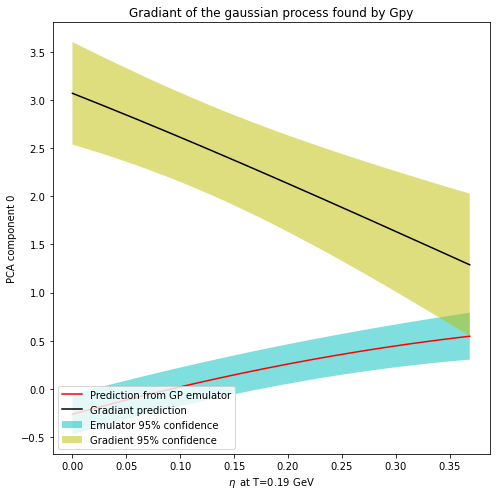

(300, 29)


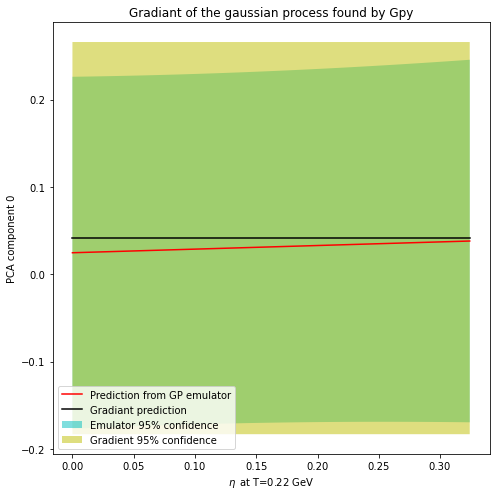

(300, 29)


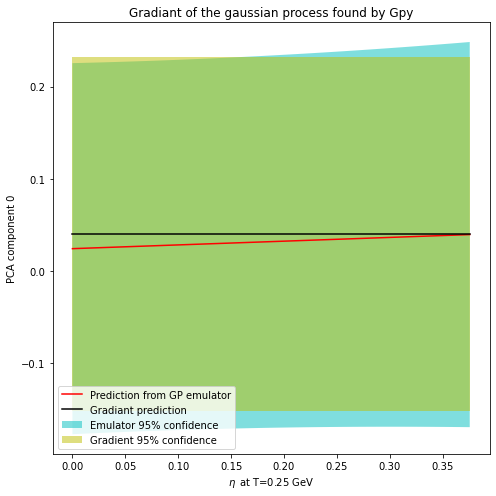

(300, 29)


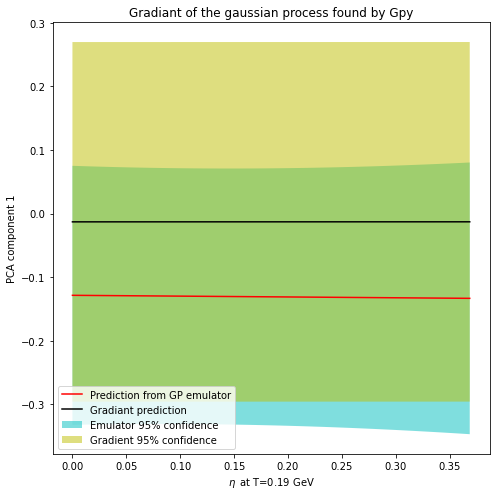

(300, 29)


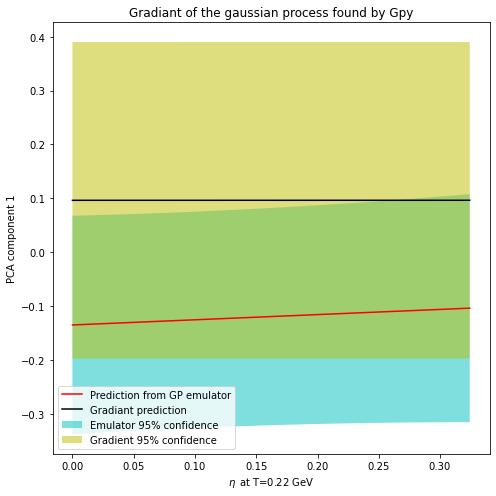

(300, 29)


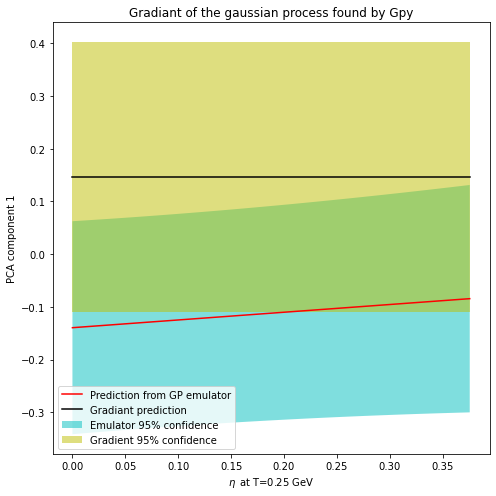

(300, 29)


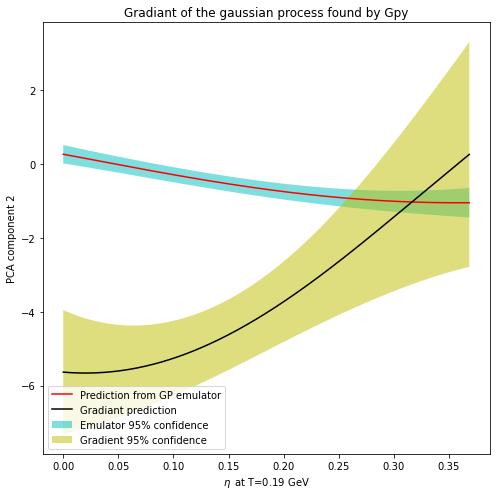

(300, 29)


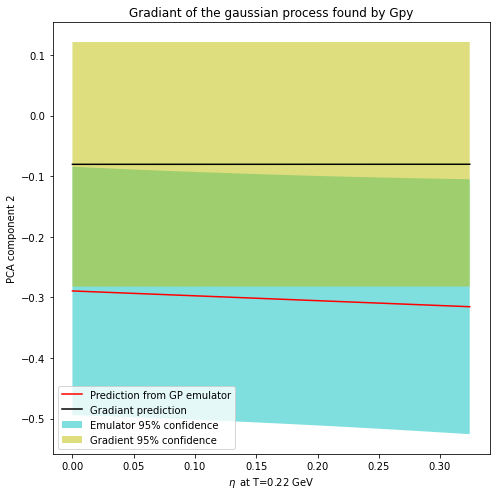

(300, 29)


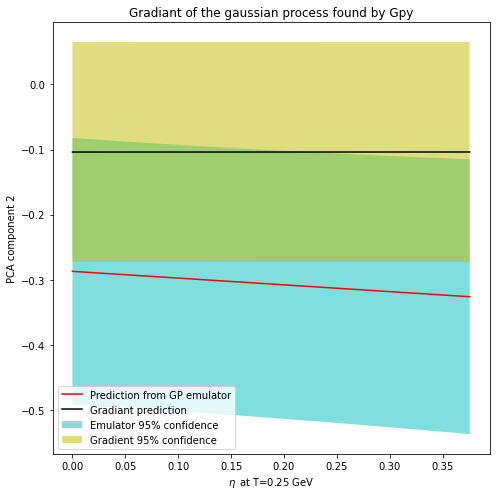

(300, 29)


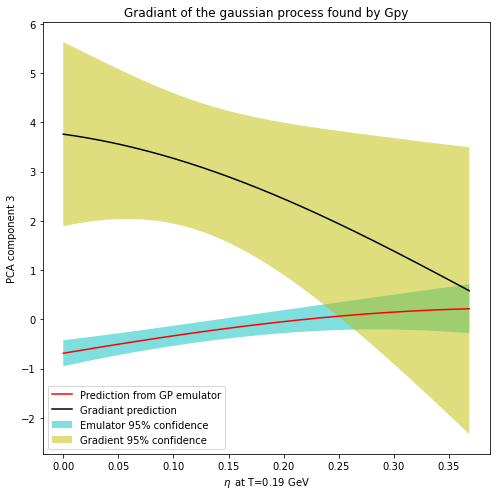

(300, 29)


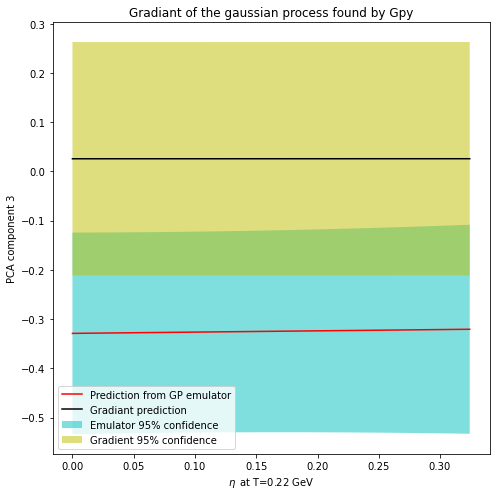

(300, 29)


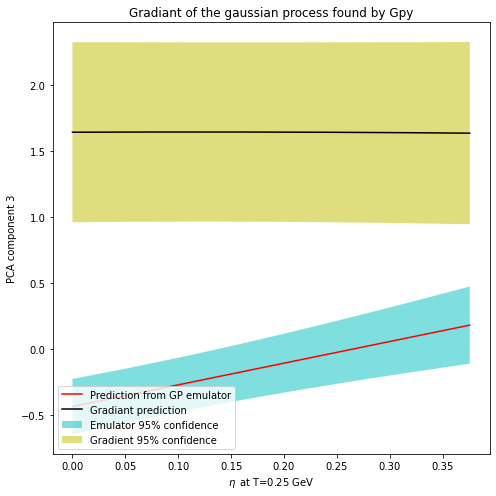

(300, 29)


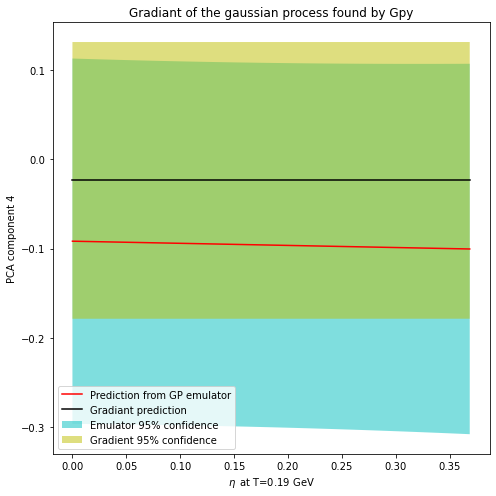

(300, 29)


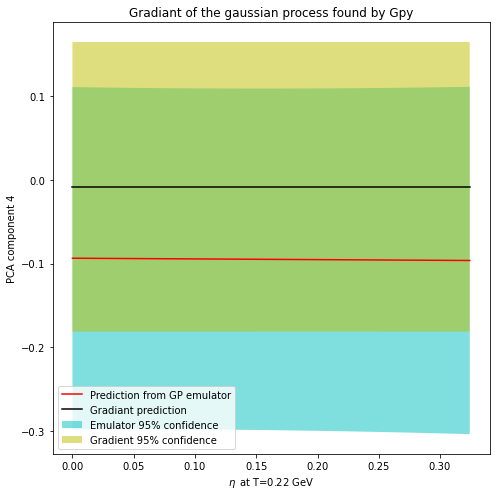

(300, 29)


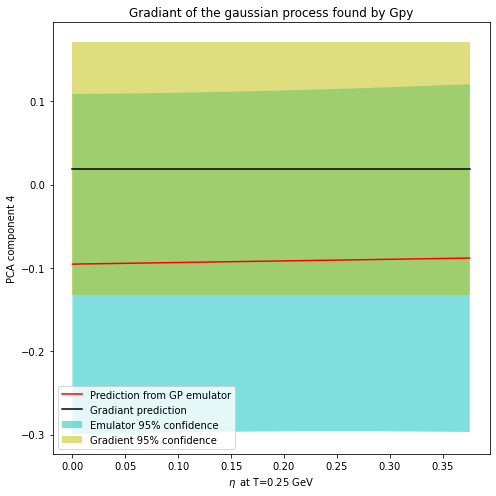

(300, 29)


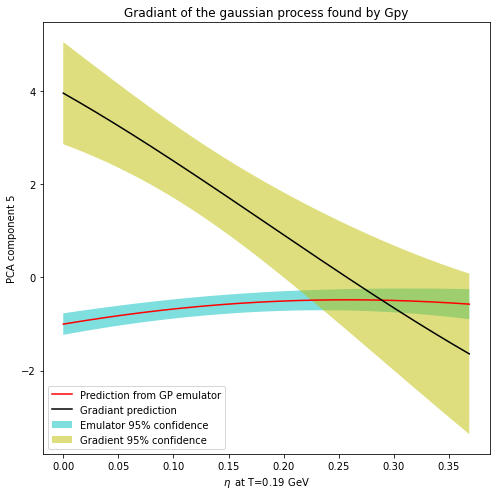

(300, 29)


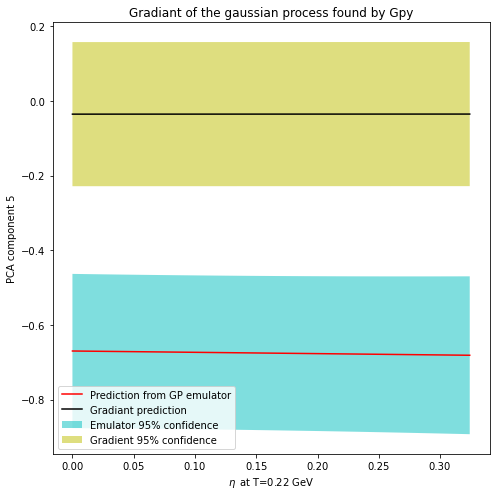

(300, 29)


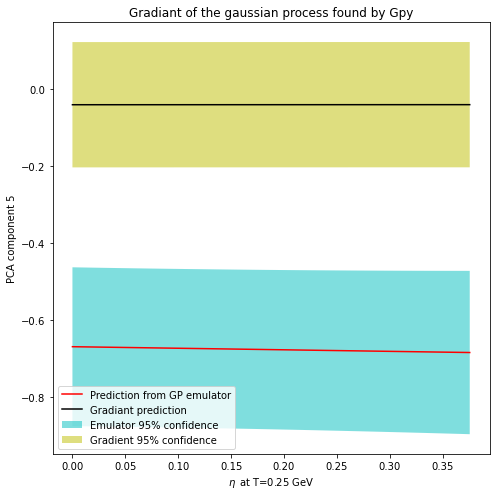

(300, 29)


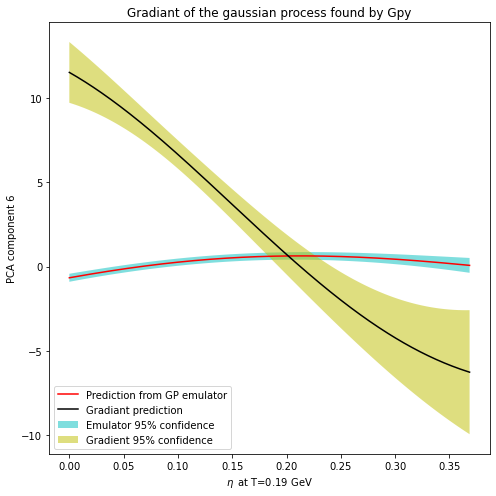

(300, 29)


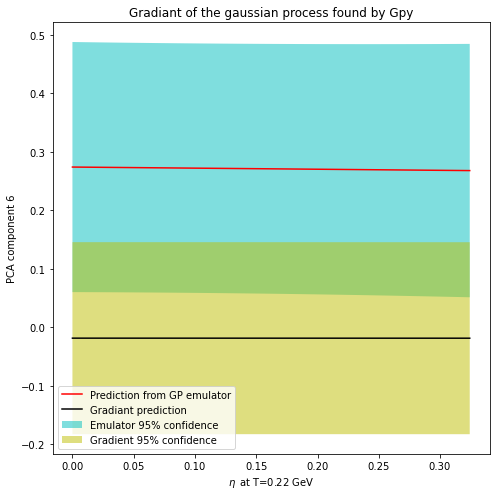

(300, 29)


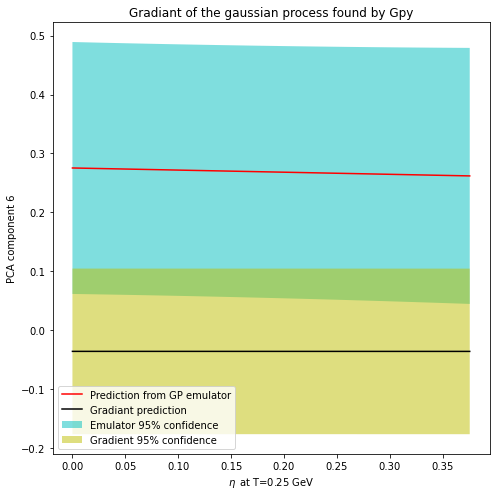

(300, 29)


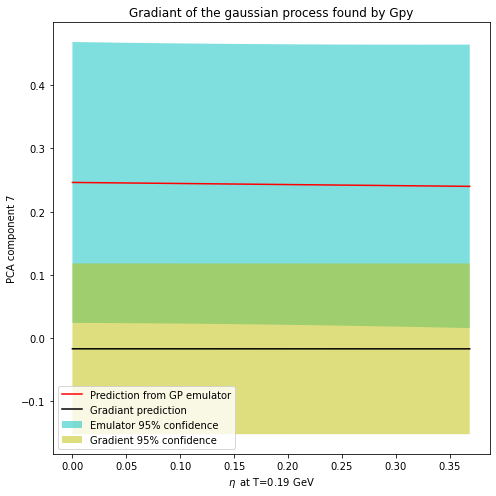

(300, 29)


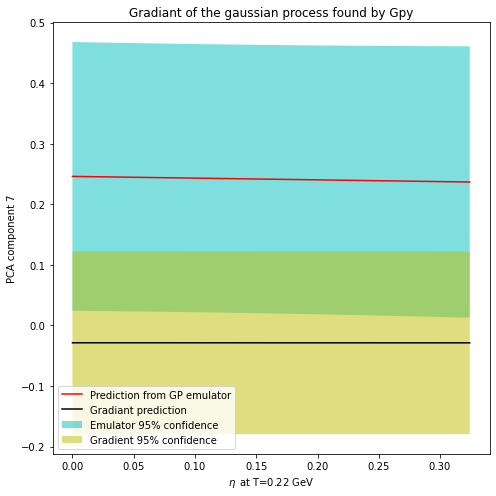

(300, 29)


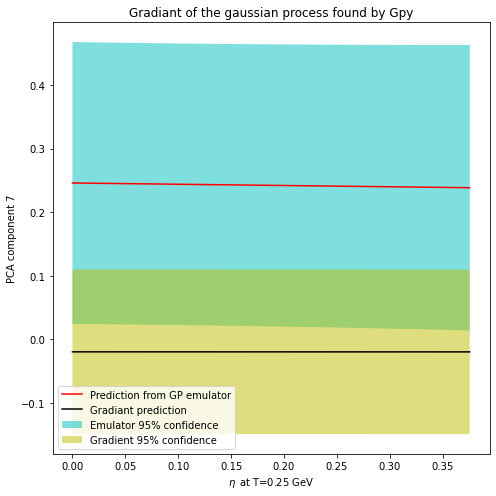

(300, 29)


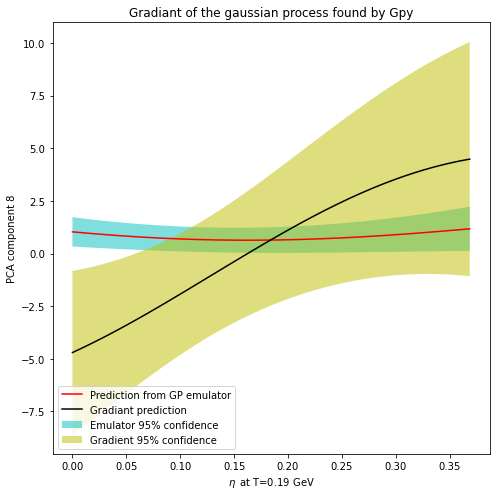

(300, 29)


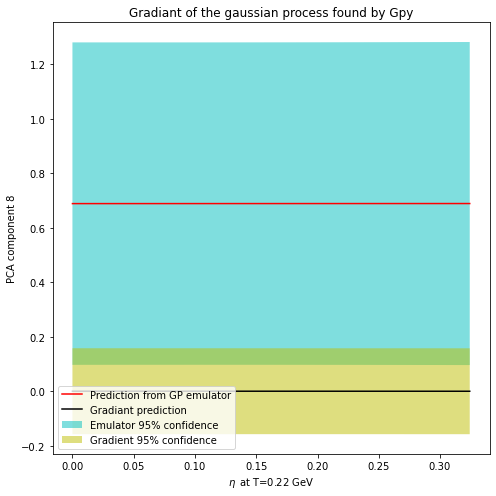

(300, 29)


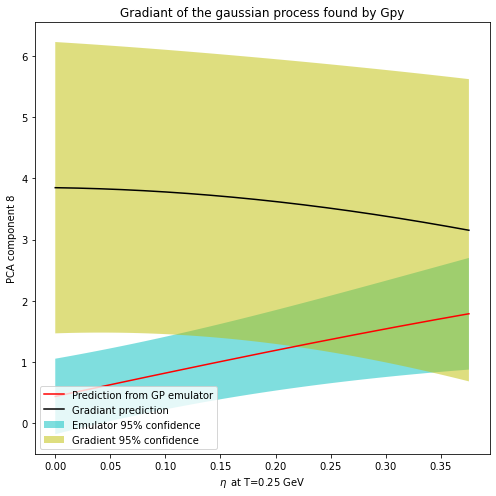

(300, 29)


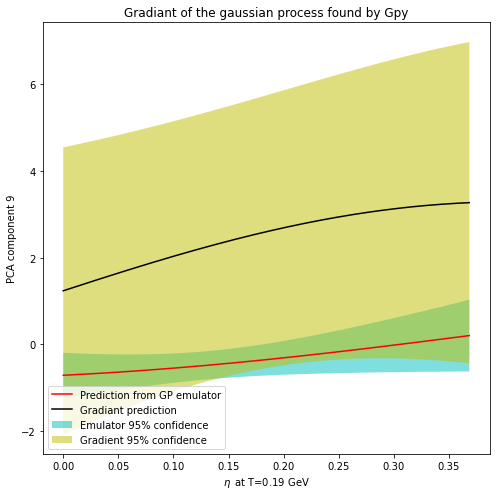

(300, 29)


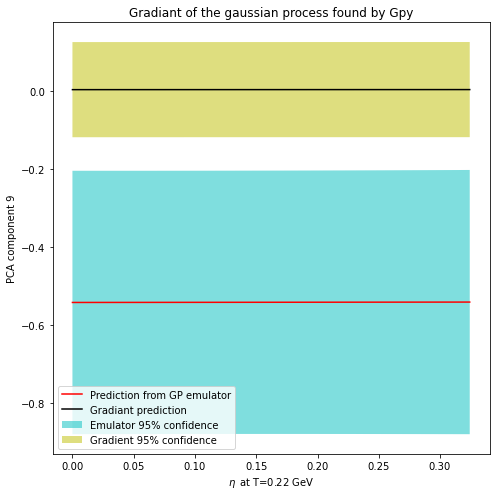

(300, 29)


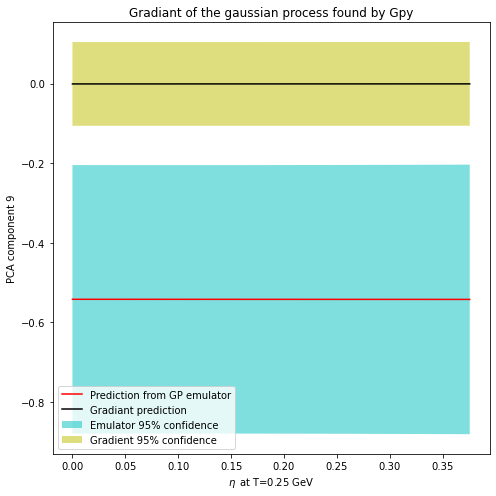

In [35]:
for i in range(0,10):
    PCAgraphs(i,GPy_emulators, model_param=11)
    PCAgraphs(i,GPy_emulators, model_param=12)
    PCAgraphs(i,GPy_emulators, model_param=13)

In [36]:
em.gps[0].get_params()["kernel__k1__k2"]

RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151])

In [37]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [38]:
GPy_emulators[4].predict(Xnew=MAP)
em.gps[4].predict(MAP)

array([-0.09244022])

In [39]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [40]:
MAP.shape

(1, 29)

In [41]:
grad_arry=np.ones((29,10))
MapObsAry=np.ones(10)
sigma_arry=np.ones((29,10))
LL,x_predict=getDesignMatrix(0,np.array(MAP_params["Pb-Pb-2760"]))
for k in range(0,10):
        m=GPy_emulators[k]
        grad,var_grad=m.predict_jacobian(Xnew=MAP)
        map_obs,_=m.predict(Xnew=MAP)
     #   print(var_grad[0].diagonal())
       # print(grad)
        grad_arry[:,k]=grad.reshape(29,)
      #  print(grad_arry)
     #   print(grad.shape)
        #var_grad=vvarrr[0] 
        l=0
        for i in var_grad[0].diagonal():
            if i<0:
                l=l+1
        print(f'pca is {k} with {l} negatives')
        sigma=np.sqrt(var_grad[0].diagonal())
        sigma_arry[:,k]=sigma.reshape(29,)
        MapObsAry[k]=map_obs[0]

MapObservabes=em._inverse_transform(MapObsAry)

pca is 0 with 0 negatives
pca is 1 with 0 negatives
pca is 2 with 0 negatives
pca is 3 with 0 negatives
pca is 4 with 0 negatives
pca is 5 with 0 negatives
pca is 6 with 0 negatives
pca is 7 with 0 negatives
pca is 8 with 0 negatives
pca is 9 with 0 negatives


In [42]:
MapObsAry.shape

(10,)

In [43]:
MapObservabes

{'dNch_deta': array([1481.58812128, 1212.02103341,  917.42647369,  623.11080913,
         408.36386032,  254.16104597,  144.9570944 ,   72.74152994]),
 'dET_deta': array([1969.03090589, 1755.72649317, 1591.85820024, 1445.65334569,
        1313.94223699, 1195.28739041, 1084.36238187,  984.61286811,
         892.0736765 ,  806.12195551,  726.24759512,  652.36693962,
         583.96556089,  522.11865637,  465.10247067,  412.70847291,
         342.56438271,  261.35735357,  194.75388174,  140.71372592,
          98.12129871,   65.42432974]),
 'dN_dy_pion': array([1372.71282403, 1122.71437056,  849.6272514 ,  577.34417919,
         379.01904855,  236.54922695,  135.43962532,   68.31004751]),
 'dN_dy_kaon': array([233.00150271, 191.59006996, 146.10287666, 100.31406283,
         66.52667068,  41.98187444,  24.33915577,  12.45921312]),
 'dN_dy_proton': array([68.29943424, 56.69463952, 43.72906246, 30.4860846 , 20.48112217,
        13.06189739,  7.63158076,  3.8924873 ]),
 'dN_dy_Lambda': array(

In [44]:
Y_exp_data['Pb-Pb-2760']['mean_pT_pion']

array([([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165])],
      dtype=[('mean', '<f8', (8,)), ('err', '<f8', (8,))])

In [45]:
grad_arry[2,:].shape

(10,)

In [46]:
dicc=em._inverse_transform(grad_arry[2,:])

In [47]:
### Get the factors I have to multiply gradients with to make them dimensio #model parameter unit in the numerator. 
Map_model_param_for_dim=MAP.reshape(29,) 
#MapObservabes=em.predict(X=Map_model_param_for_dim.reshape(1,29))


In [48]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters


dicc=em._inverse_transform(grad_arry[2,:])

def sensitivity_plot_scott_grouped(centrality_begin,model_param):
    width = 0.35  # The width of the bars
    modelparam_Gradient=[] # Gradients at MAP wrt the model_param
    modelparam_Grad_sigma=[] # Variance of the gradient at MAP wrt the model_param
    MapObservabesUnits_1=[] # Parameter values at MAP for low centrality
    MapObservabesUnits_2=[] # Parameter values at MAP for high centrality
    sensitivity_list_1=[] # Sensitivity calculated for low centrality
    sensitivity_list_2=[] # Sensitivity calculated for high centrality
    
    X_values=[] # Value in the xaxis from 0 to n_observable_types * 2 
    X_name=[] # Name of the observables
    label_1=[] # centrality of low centrality obs
    label_2=[] # centrality of high centrality obs
    temp_dic_all_grad=em._inverse_transformm(grad_arry[model_param,:])
    temp_dic_all_var= em._inverse_transform(sigma_arry[model_param,:])
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(12, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):
        if (i!=5) & (i!=6) & (i!=7):
            sensitivity_list_1.append(temp_dic_all_grad[key][0])
            #print(temp_dic_all_grad[key][0])
            MapObservabesUnits_1.append(MapObservabes[key][0])
          #  X_values.append(2*l)
            X_name.append(dic_keys[i])
            label_1.append(str(obs_cent_list["Pb-Pb-2760"][key][0]))
            sensitivity_list_2.append(temp_dic_all_grad[key][3])
           # X_values.append(2*l+1)
           # X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
            label_2.append(str(obs_cent_list["Pb-Pb-2760"][key][3]))
            l=l+1
            MapObservabesUnits_2.append(MapObservabes[key][3])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    X_values=np.arange(len(MapObservabesUnits_1))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list_1=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_list_1)]).flatten()
    sensitivity_list_2=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_list_2)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
   # positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
   # barlist=ax.bar(X_values,sensitivity_list)#,yerr=sensitivity_error)

    rects1 = ax.bar(X_values - width/2, sensitivity_list_1, width, label='Low centrality')
    rects2 = ax.bar(X_values + width/2, sensitivity_list_2, width, label='High centrality')

    
   # for j,difference in enumerate(positives):
    #    if difference==False:
     #       barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(f'S[{all_model_labels[model_param]}]',fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    ax.set_xticks(X_values)
    ax.set_xticklabels(X_name)
    #plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
   # plt.tight_layout()
  #  blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
  #  cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
  #  plt.legend(handles=[blue_patch, cyan_patch])
    def autolabel(rects,labels):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            if height<0:
                va='bottom'
                space=4
            else:
                va='top'
                space=40
            ax.annotate(labels[i],
                   # xy=(rect.get_x() + rect.get_width() / 2, height),
                    xy=(rect.get_x() + rect.get_width() / 2, 0),
                    xytext=(0,space),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va=va,rotation='90')
    plt.legend()
    autolabel(rects1,label_1)
    autolabel(rects2,label_2)
    plt.tight_layout()
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/without_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

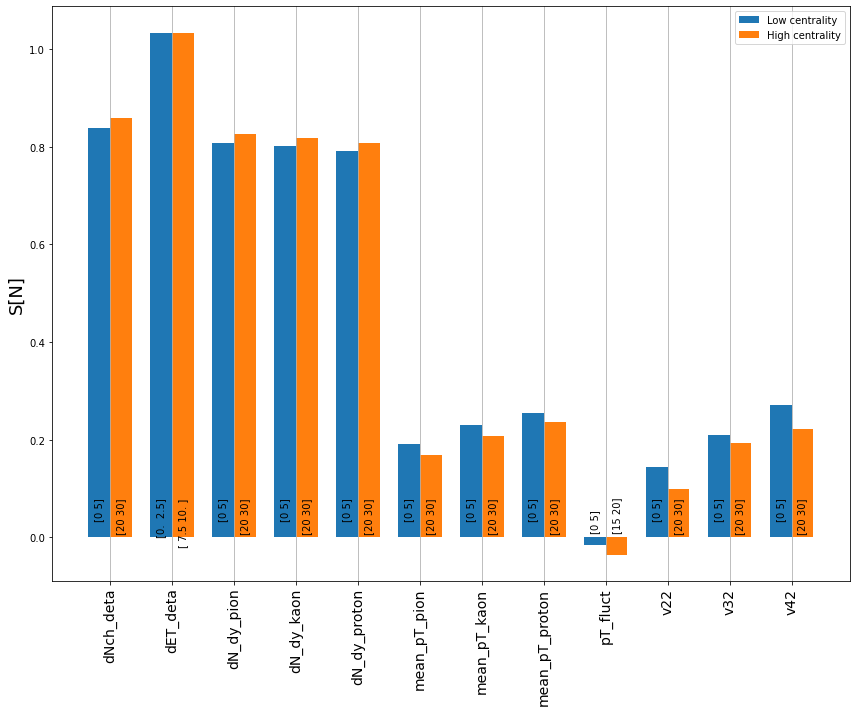

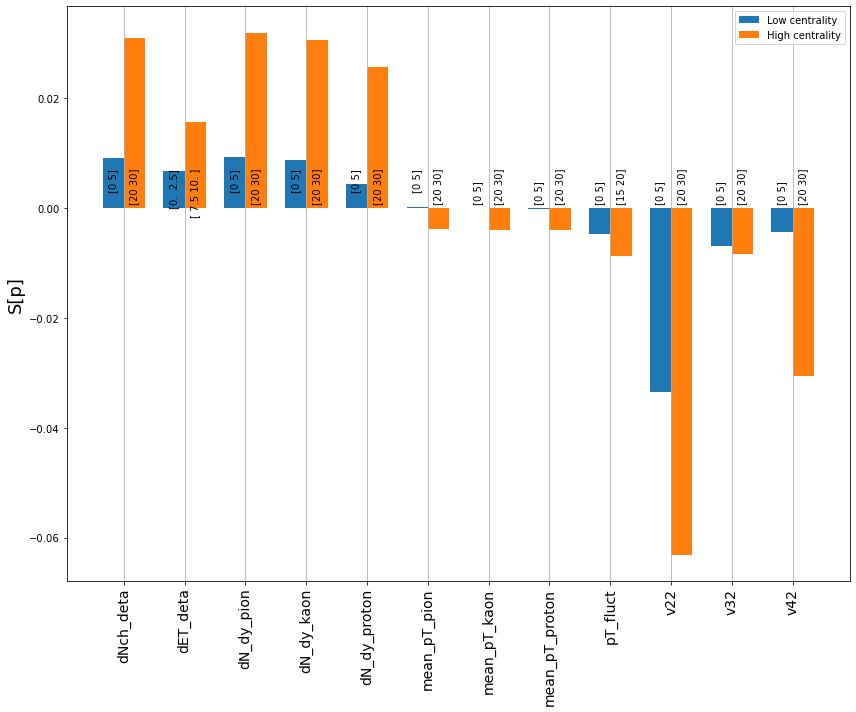

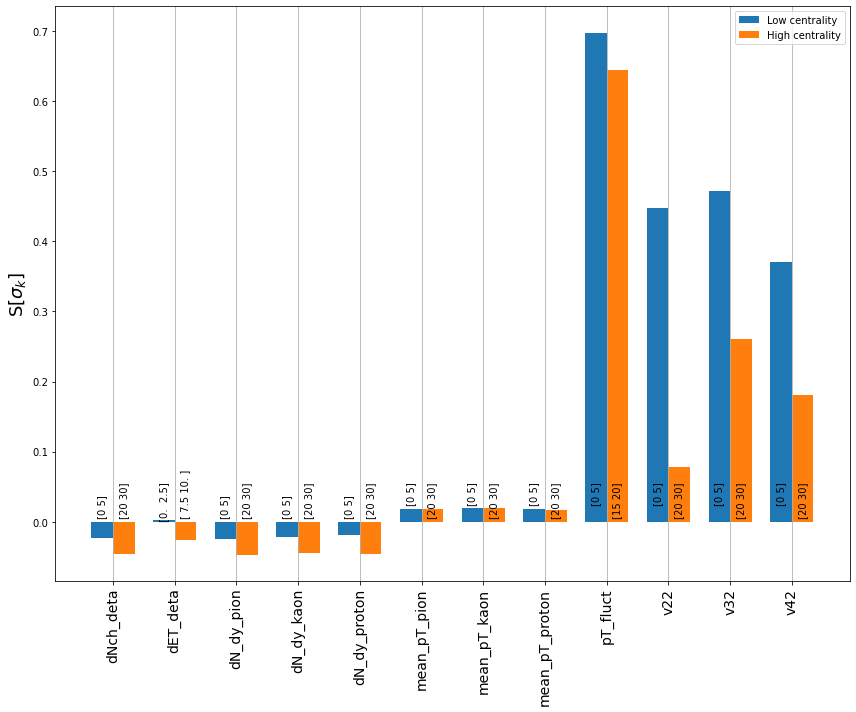

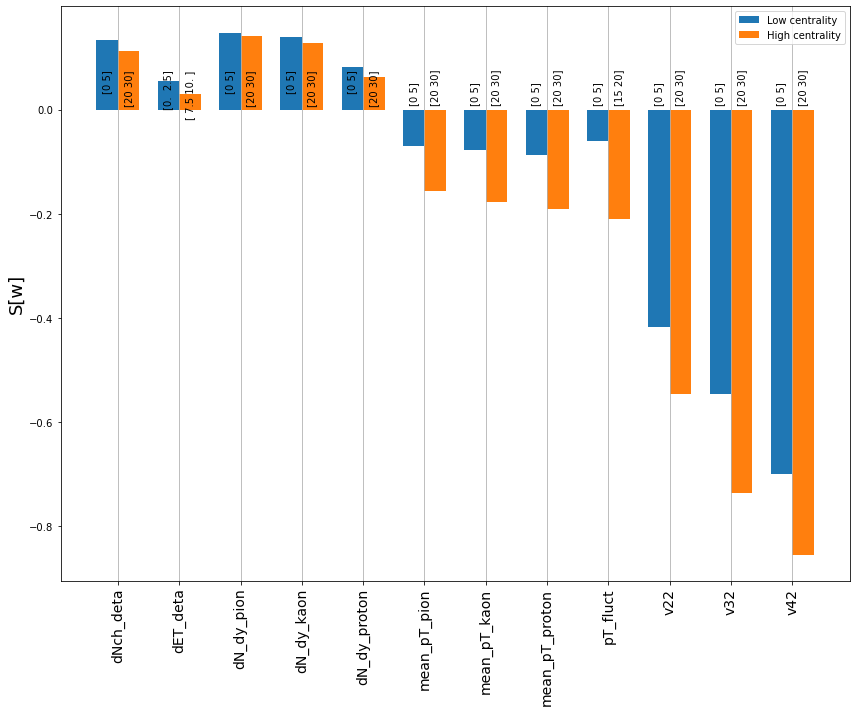

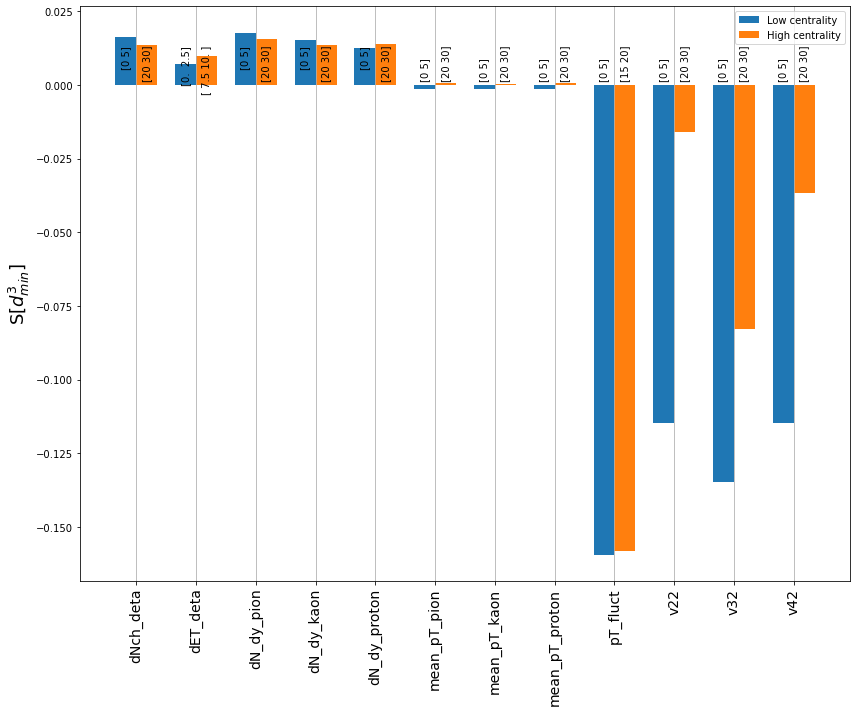

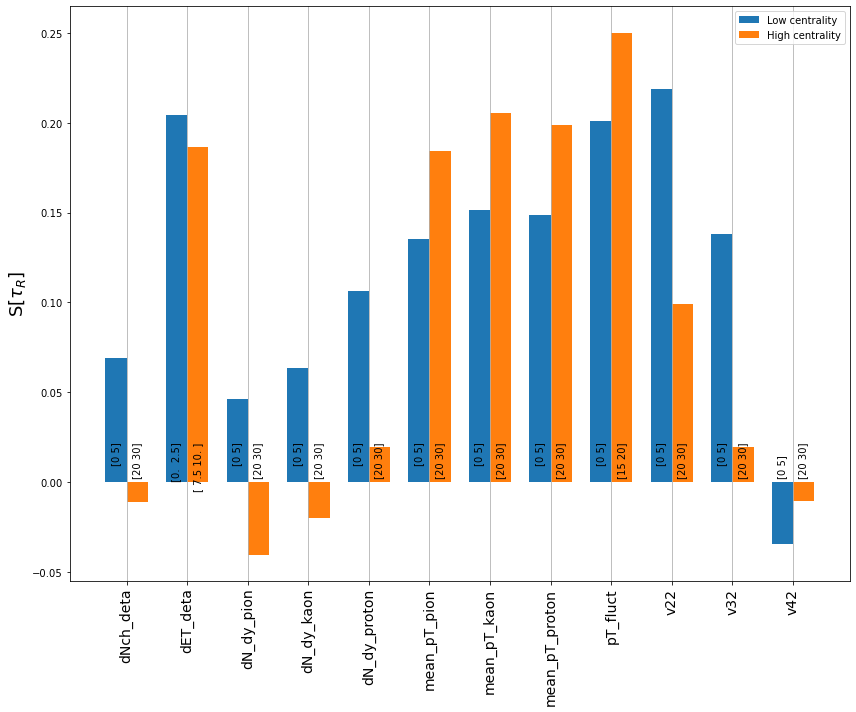

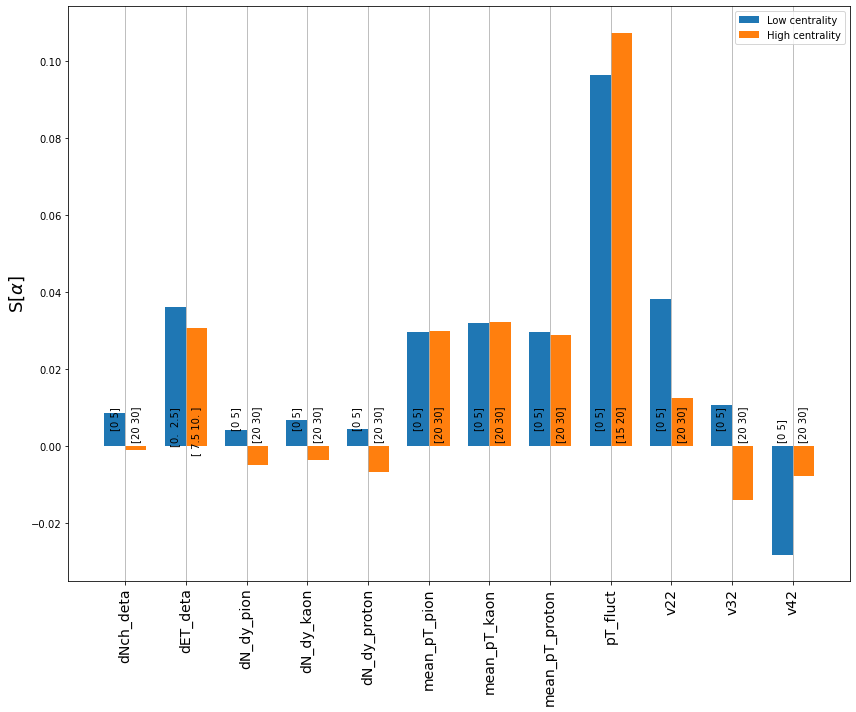

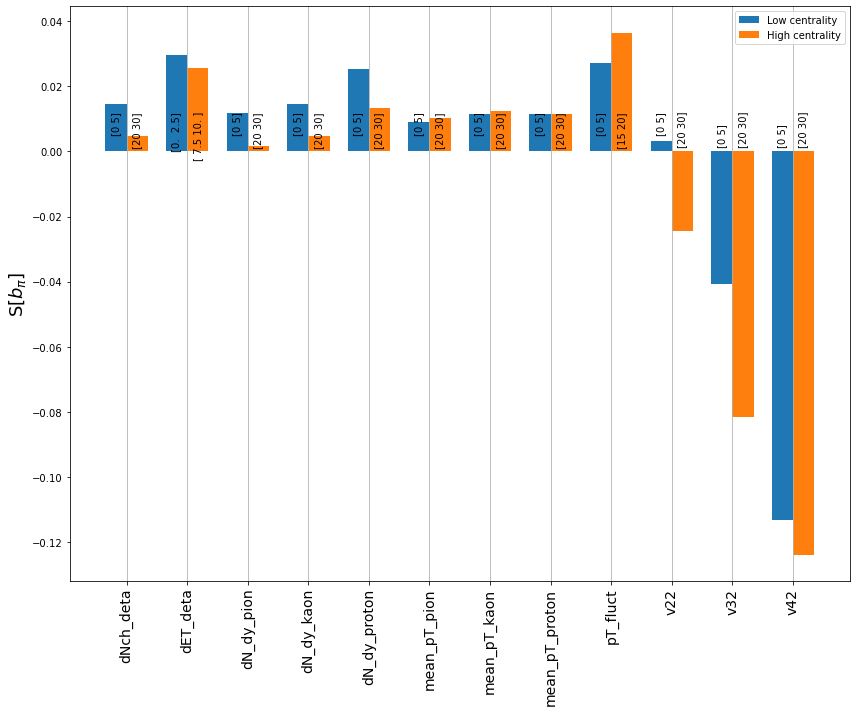

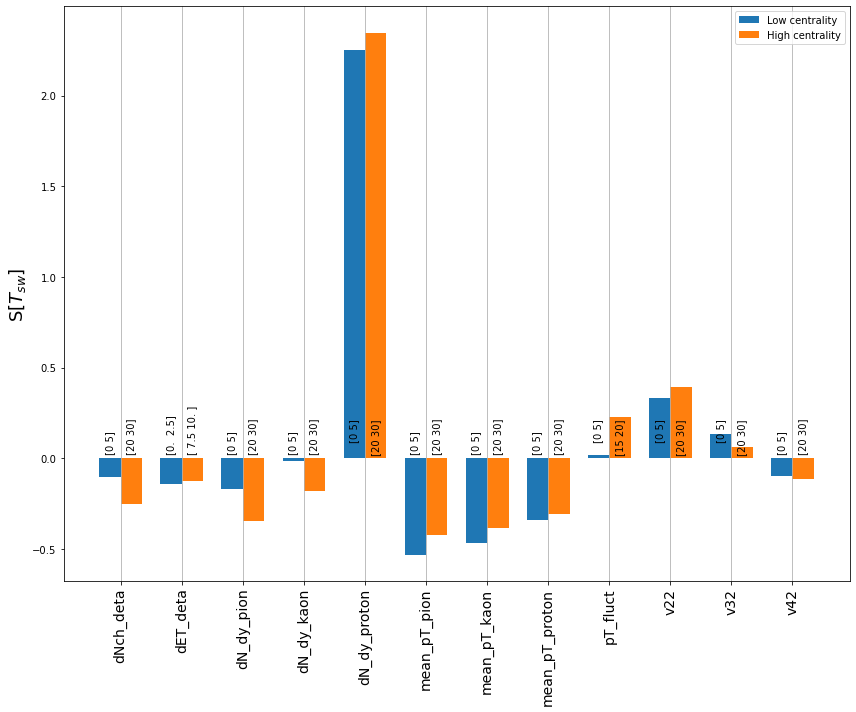

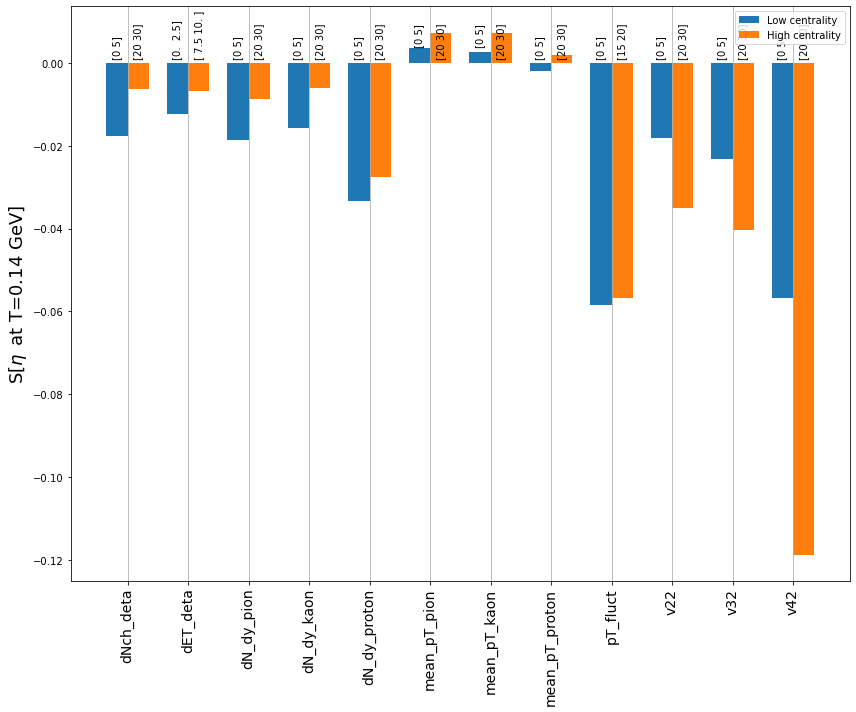

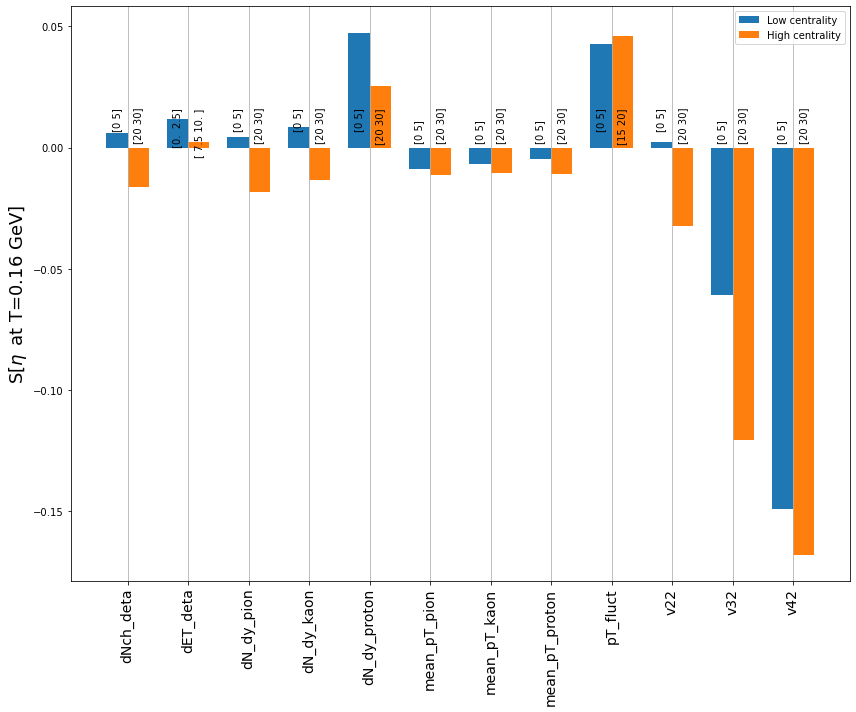

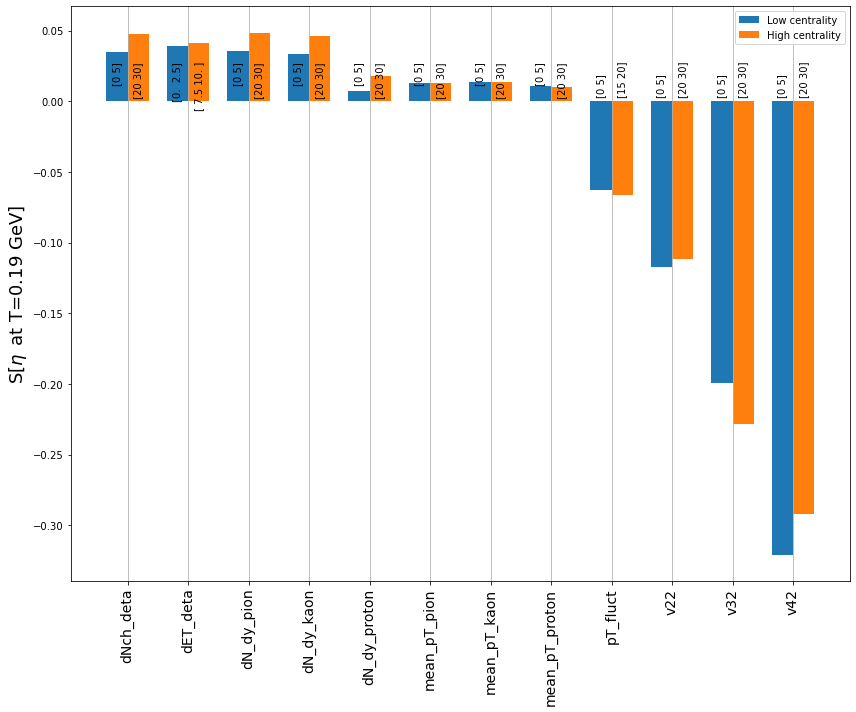

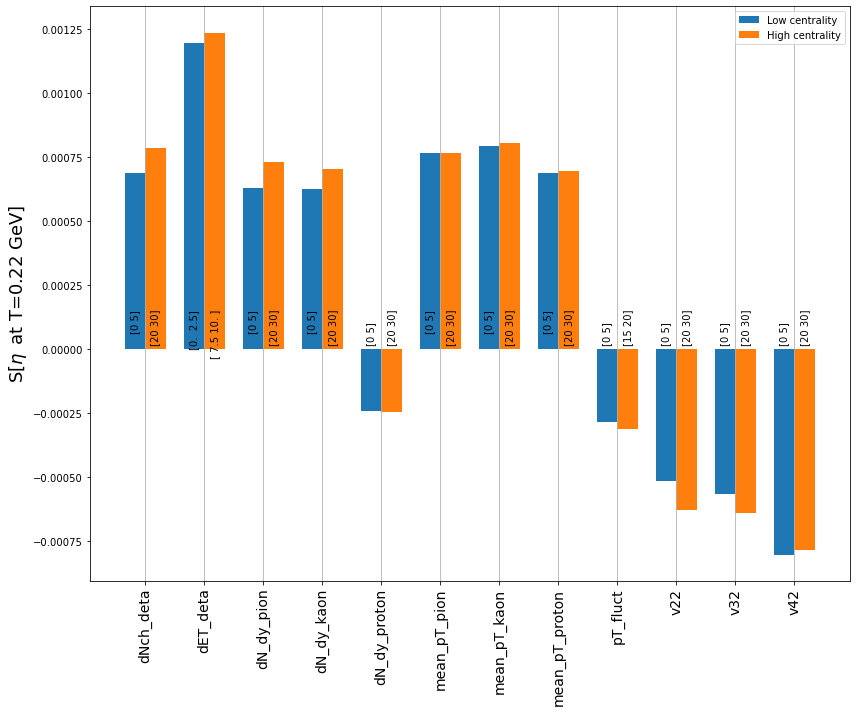

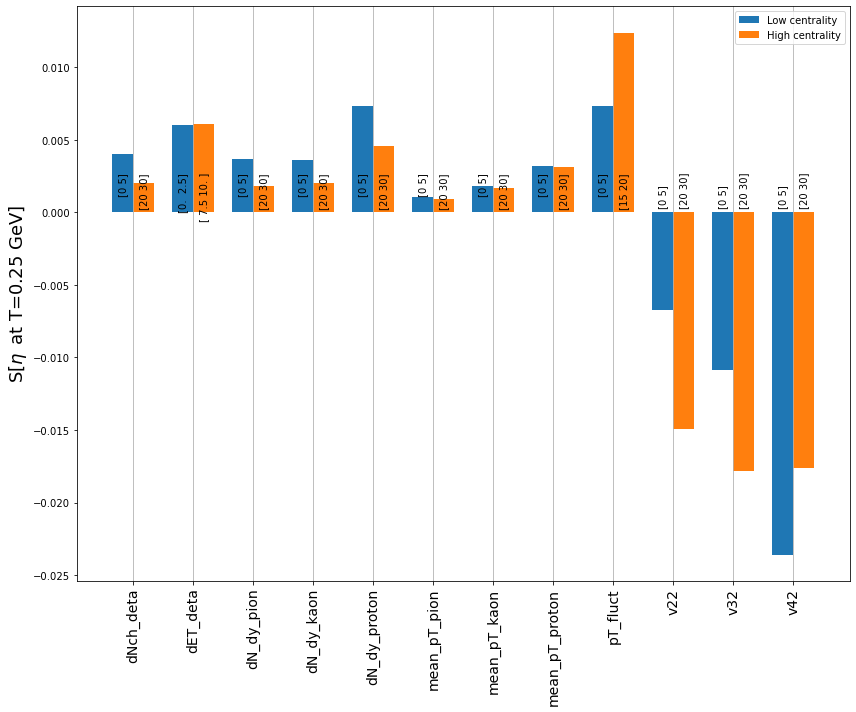

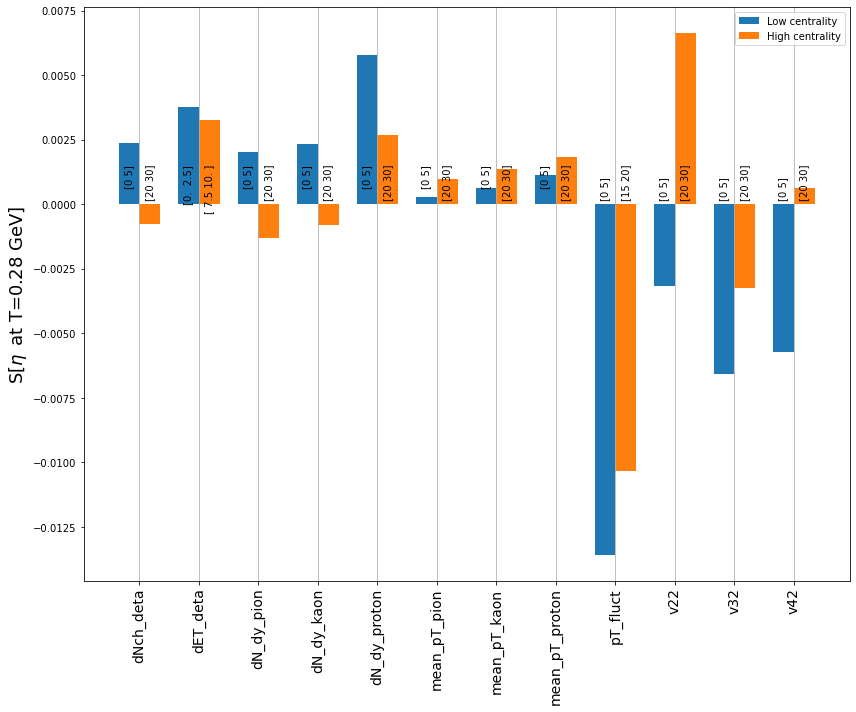

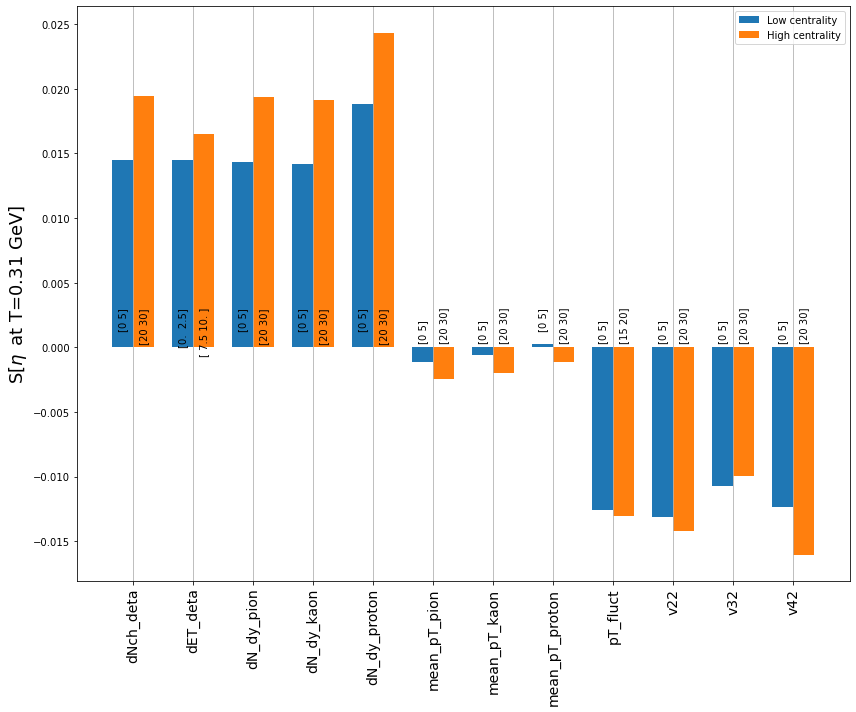

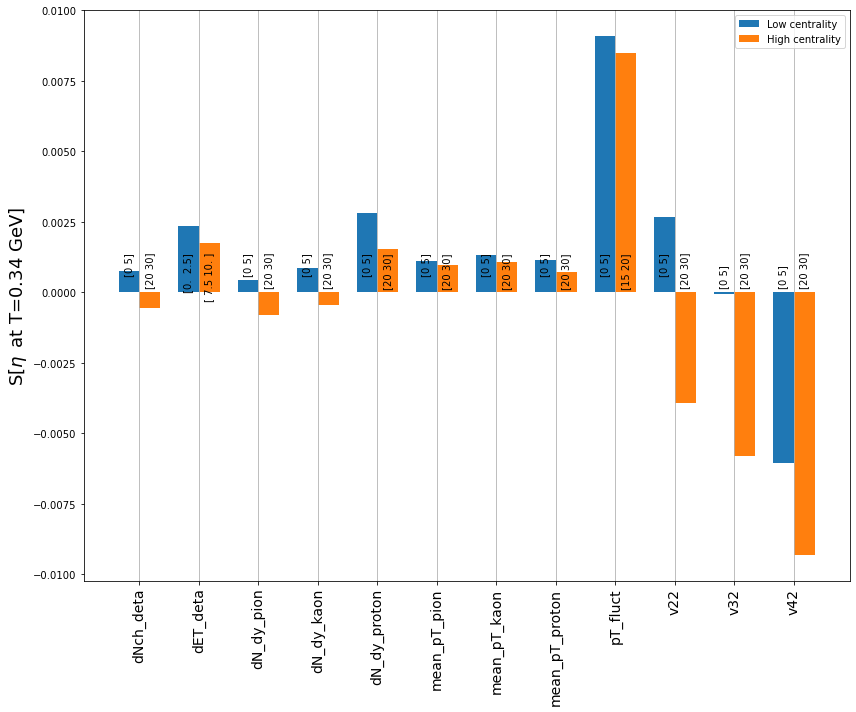

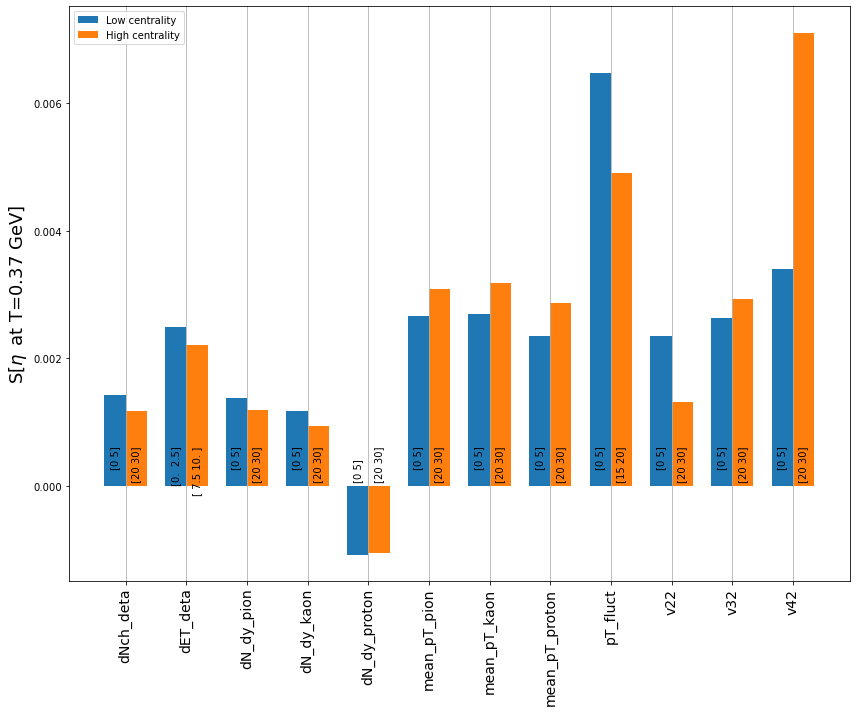

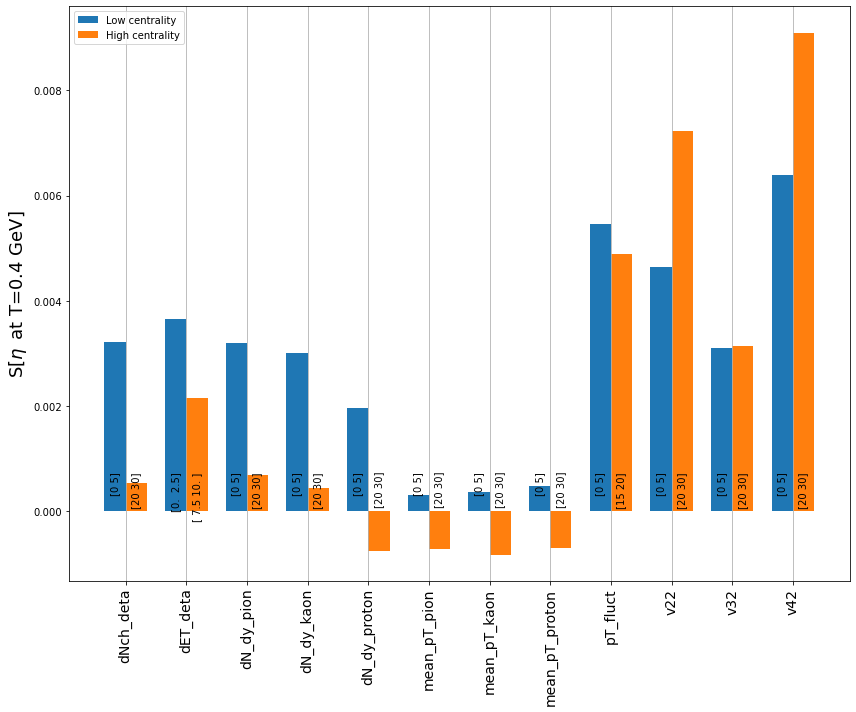

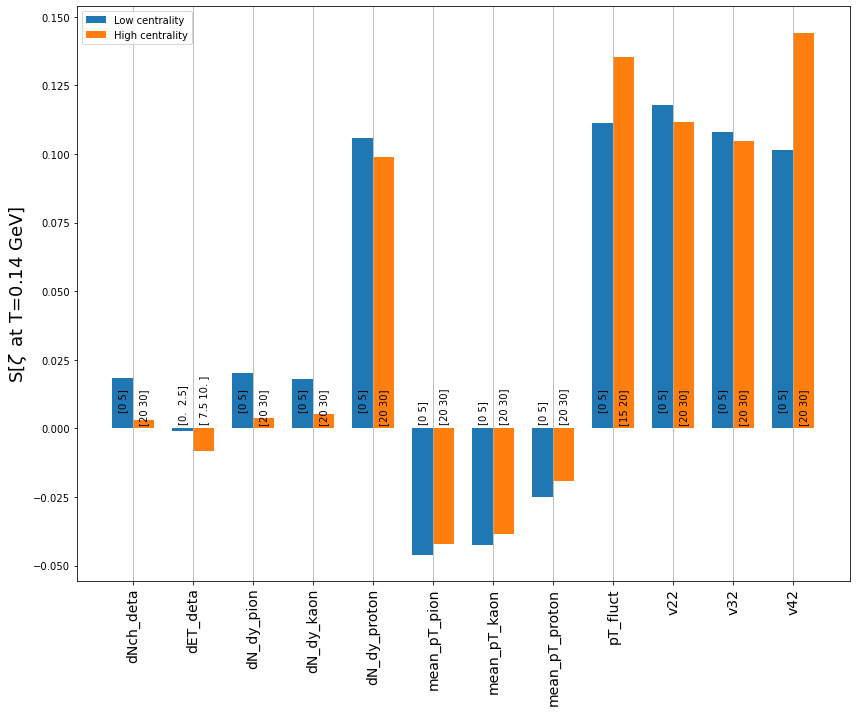

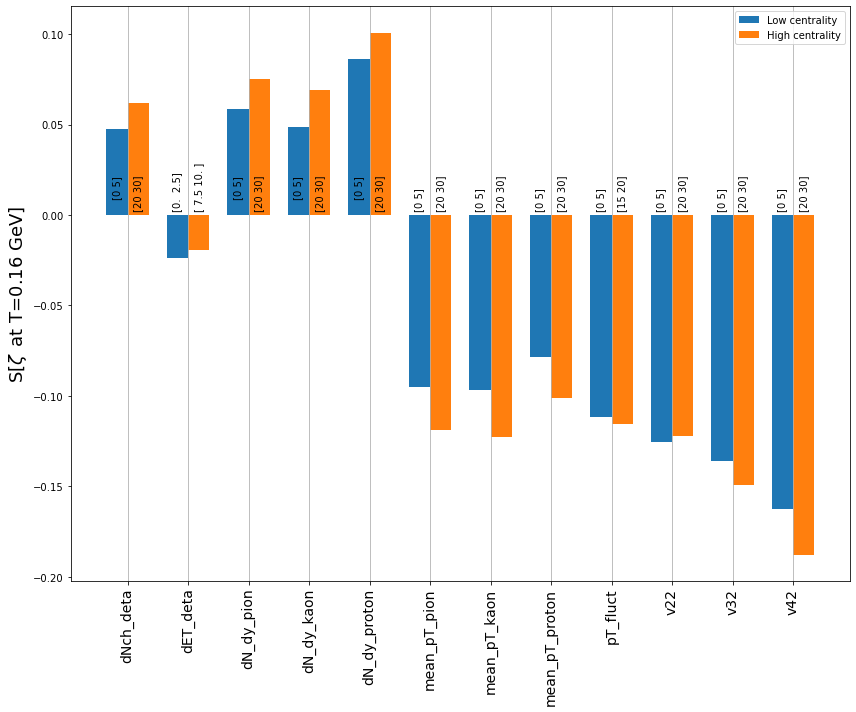

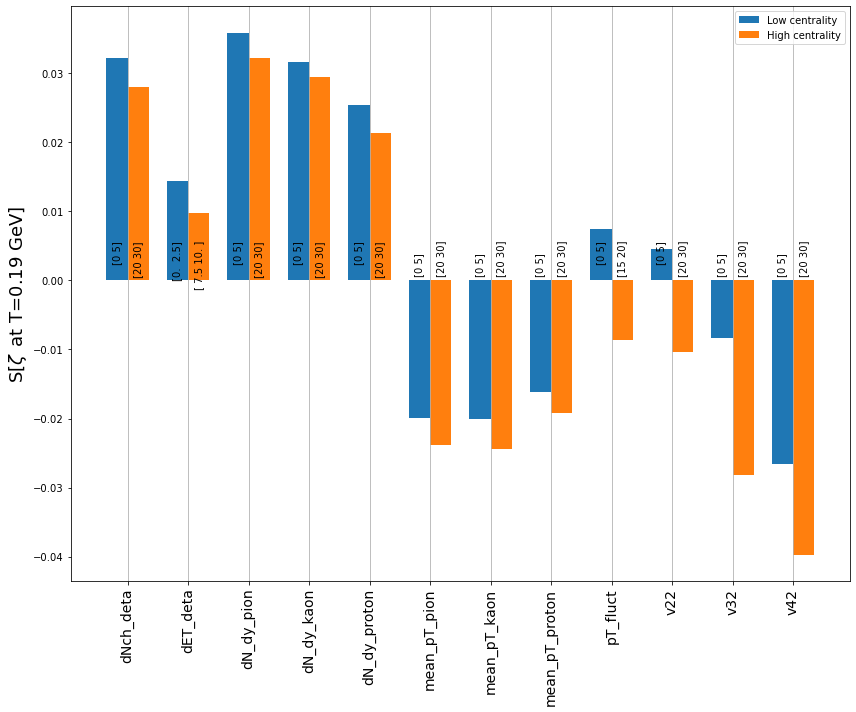

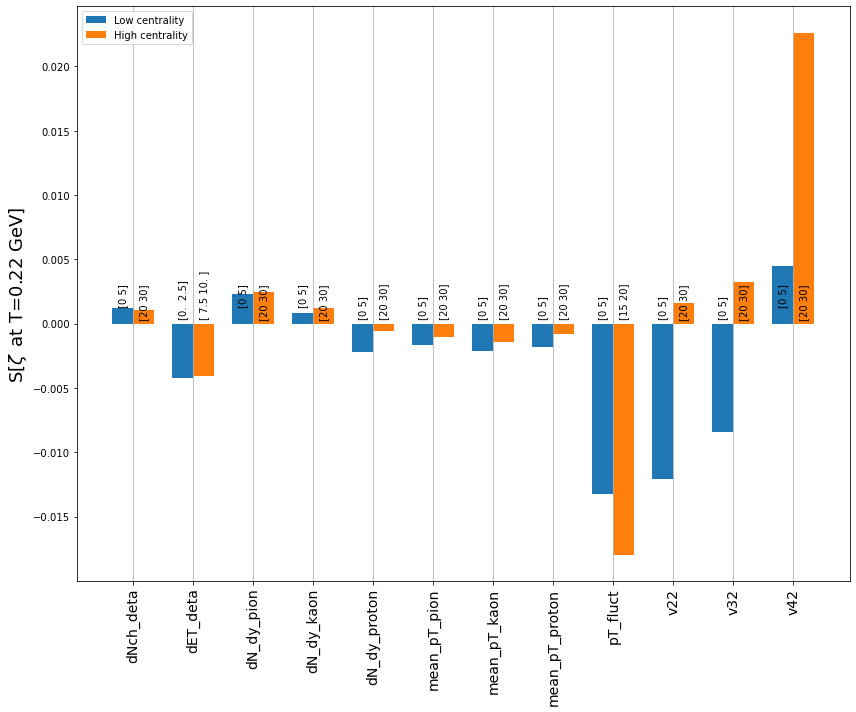

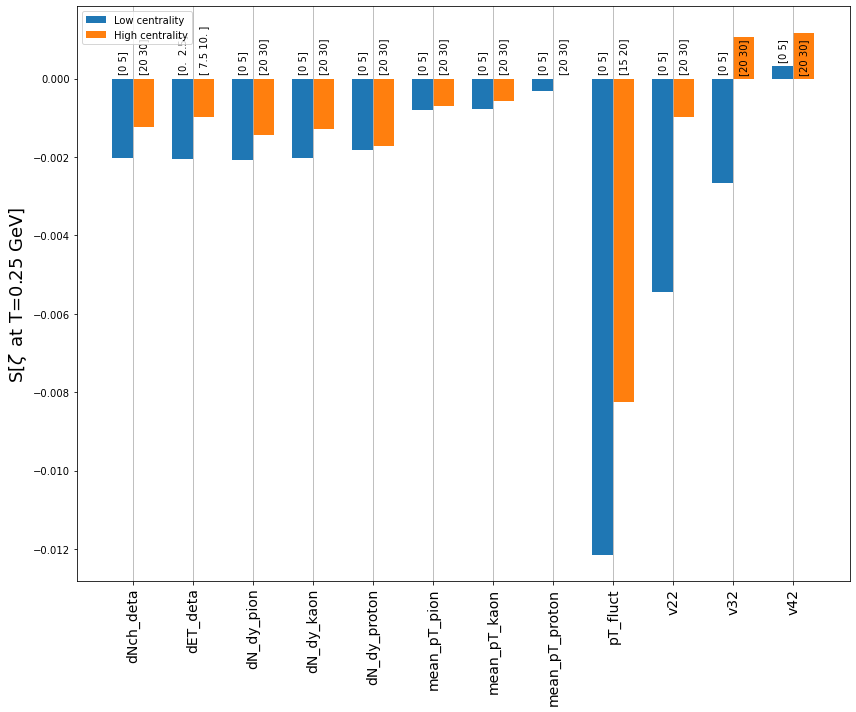

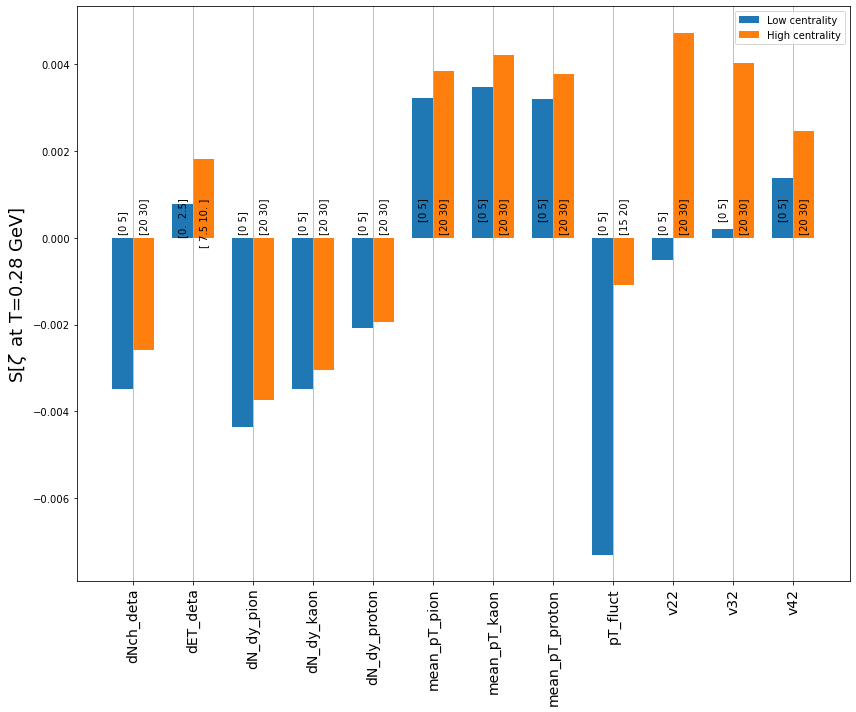

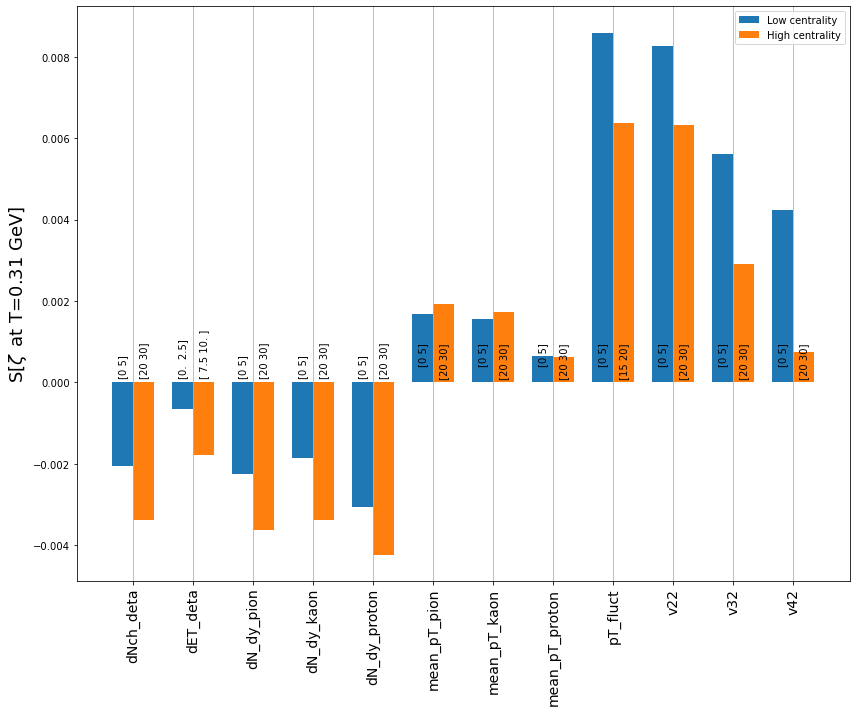

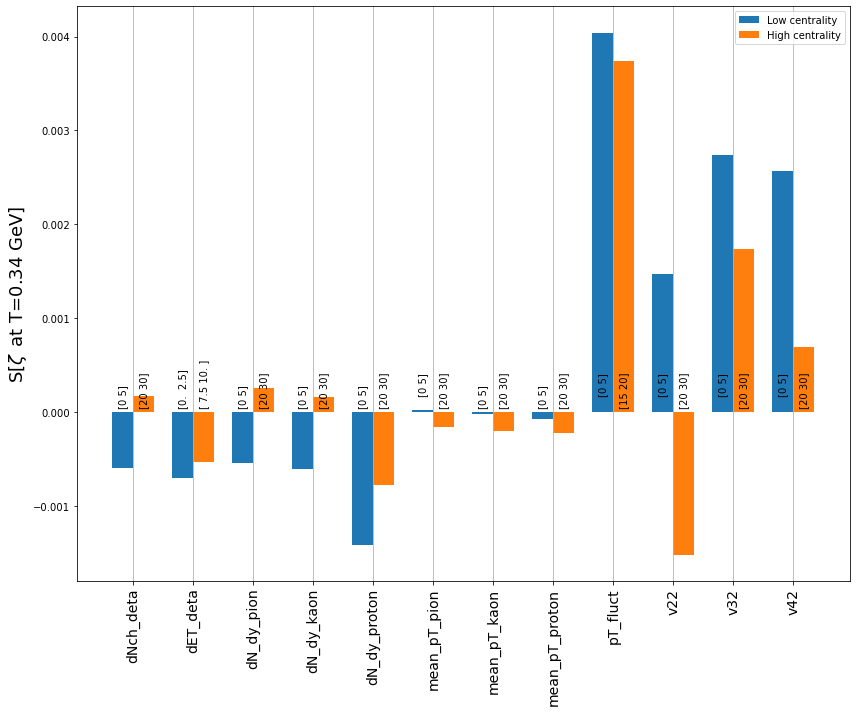

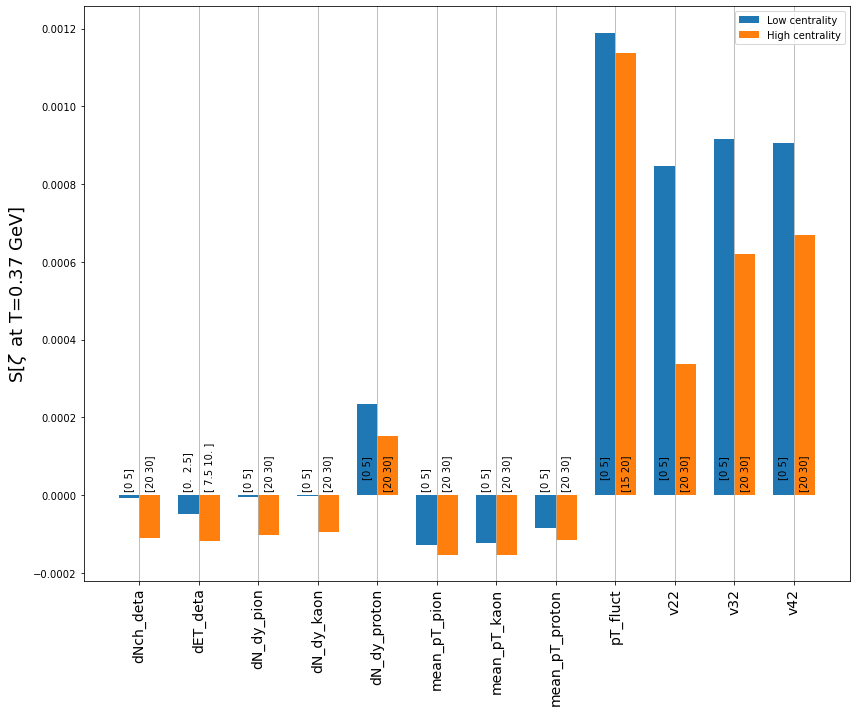

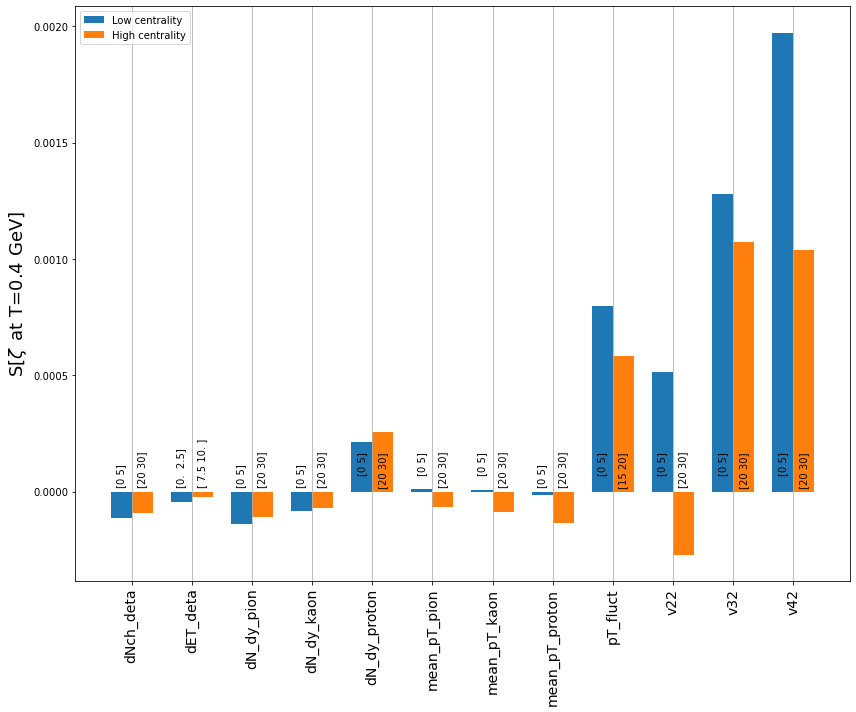

In [49]:
for i in range(0,29):
    sensitivity_plot_scott_grouped(40,i)

In [50]:
coefficients={}
for i in range(10):
    trial_x=np.zeros(10)
    trial_x[i]=1
    coefficients[i]=em._inverse_transformm(trial_x)

In [51]:
def inverse_transform_variance(PCA_GE_var):
    observables={}
    for keys in coefficients[0]:
        temp=np.zeros(len(coefficients[0][keys]))
        for k,t in enumerate(PCA_GE_var):
            temp+=((coefficients[k][keys])**2)*t
        observables[keys]=temp 
    return observables

In [52]:
coefficients[2]

{'dNch_deta': array([26.25086024, 15.75093079,  7.82586912,  2.15807369, -1.3266329 ,
        -2.92548764, -3.11676884, -2.8949989 ]),
 'dET_deta': array([13.96666775,  2.1905596 ,  0.74978081, -0.74479509, -3.01377083,
        -3.60659354, -3.52791252, -4.34110124, -4.73590369, -4.76560747,
        -4.95423676, -5.27268601, -5.3224885 , -5.61236308, -5.69468131,
        -5.7304465 , -5.37802788, -4.94616273, -4.21959977, -3.9463704 ,
        -3.59156323, -3.02040791]),
 'dN_dy_pion': array([23.16716699, 13.35156583,  5.94103729,  0.79856587, -2.22928675,
        -3.4862118 , -3.43471052, -3.02160043]),
 'dN_dy_kaon': array([ 4.49180137,  2.84736414,  1.57836791,  0.60246671, -0.01037077,
        -0.32637435, -0.41225328, -0.41950259]),
 'dN_dy_proton': array([9.35163974, 7.68577049, 5.92221782, 4.13715012, 2.77392906,
        1.73902185, 0.98652883, 0.45239966]),
 'dN_dy_Lambda': array([5.60377909, 4.61144283, 3.51870362, 2.02039641, 0.77745289]),
 'dN_dy_Omega': array([0.28917303, 0.

In [53]:
inverse_transform_variance(sigma_arry[1,:]**2)

{'dNch_deta': array([117.70609407,  84.567373  ,  53.42873278,  28.86062398,
         14.89887758,   7.11839854,   3.19559127,   1.31548579]),
 'dET_deta': array([216.48394319, 175.55799191, 146.82406775, 121.90181132,
        103.15719966,  88.8187221 ,  75.18503211,  64.37369557,
         54.61237162,  46.4996609 ,  39.24887648,  32.186447  ,
         27.25506245,  22.72041101,  19.14683308,  16.09392873,
         12.43237176,   8.47828913,   5.70915332,   3.74455698,
          2.37865872,   1.47203371]),
 'dN_dy_pion': array([103.90494042,  75.8056624 ,  48.48352028,  26.55832309,
         13.91369268,   6.6663862 ,   2.97378707,   1.20552275]),
 'dN_dy_kaon': array([2.73543713, 1.98806546, 1.29486721, 0.72905017, 0.39009869,
        0.19286159, 0.08905141, 0.03765524]),
 'dN_dy_proton': array([0.56108368, 0.40343544, 0.25269189, 0.13461332, 0.06864929,
        0.03274892, 0.01497509, 0.00631953]),
 'dN_dy_Lambda': array([0.1677174 , 0.11843533, 0.07274599, 0.02742931, 0.00604571]),

In [54]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters

import math
dicc=em._inverse_transform(grad_arry[2,:])

def sensitivity_plot_scott_grouped_with_error(centrality_begin,model_param):
    width = 0.35  # the width of the bars
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    MapObservabesUnits_1=[]
    MapObservabesUnits_2=[]
    sensitivity_list_1=[]
    sensitivity_error_1=[]
    sensitivity_list_2=[]
    sensitivity_error_2=[]

    X_values=[]
    X_name=[]
    label_1=[]
    label_2=[]
    temp_dic_all_grad=em._inverse_transformm(grad_arry[model_param,:])
   # temp_dic_all_var=em._inverse_transformm(sigma_arry[model_param,:])
    temp_dic_all_var=inverse_transform_variance(sigma_arry[model_param,:]**2)
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):
        if (i!=5) & (i!=6) & (i!=7):
            sensitivity_list_1.append(temp_dic_all_grad[key][0])
            sensitivity_error_1.append(temp_dic_all_var[key][0])
            #print(temp_dic_all_grad[key][0])
            MapObservabesUnits_1.append(MapObservabes[key][0])
          #  X_values.append(2*l)
            X_name.append(dic_keys[i])
            label_1.append(str(obs_cent_list["Pb-Pb-2760"][key][0]))
            sensitivity_list_2.append(temp_dic_all_grad[key][3])
            sensitivity_error_2.append(temp_dic_all_var[key][3])
           # X_values.append(2*l+1)
           # X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
            label_2.append(str(obs_cent_list["Pb-Pb-2760"][key][3]))
            l=l+1
            MapObservabesUnits_2.append(MapObservabes[key][3])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    X_values=np.arange(len(MapObservabesUnits_1))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list_1=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_list_1)]).flatten()
    sensitivity_error_1=np.array([(math.sqrt(values)*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_error_1)]).flatten()
 #   print(len(sensitivity_list_2),len(MapObservabesUnits_2))

    sensitivity_list_2=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_list_2)]).flatten()
    sensitivity_error_2=np.array([(math.sqrt(values)*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_error_2)]).flatten()



    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
   # positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
   # barlist=ax.bar(X_values,sensitivity_list)#,yerr=sensitivity_error)

    rects1 = ax.bar(X_values - width/2, sensitivity_list_1,width, yerr=sensitivity_error_1, label='Low centrality')
    rects2 = ax.bar(X_values + width/2, sensitivity_list_2, width, yerr=sensitivity_error_2, label='High centrality')

    
   # for j,difference in enumerate(positives):
    #    if difference==False:
     #       barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(all_model_labels[model_param],fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    ax.set_xticks(X_values)
    ax.set_xticklabels(X_name)
    #plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
   # plt.tight_layout()
  #  blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
  #  cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
  #  plt.legend(handles=[blue_patch, cyan_patch])
    def autolabel(rects,labels):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            if height<0:
                va='top'
                space=40
            else:
                va='bottom'
                space=-40
            ax.annotate(labels[i],
                   # xy=(rect.get_x() + rect.get_width() / 2, height),
                    xy=(rect.get_x() + rect.get_width() / 2, 0),
                    xytext=(0,space),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va=va,rotation='90')
    plt.legend()
    autolabel(rects1,label_1)
    autolabel(rects2,label_2)
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/with_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

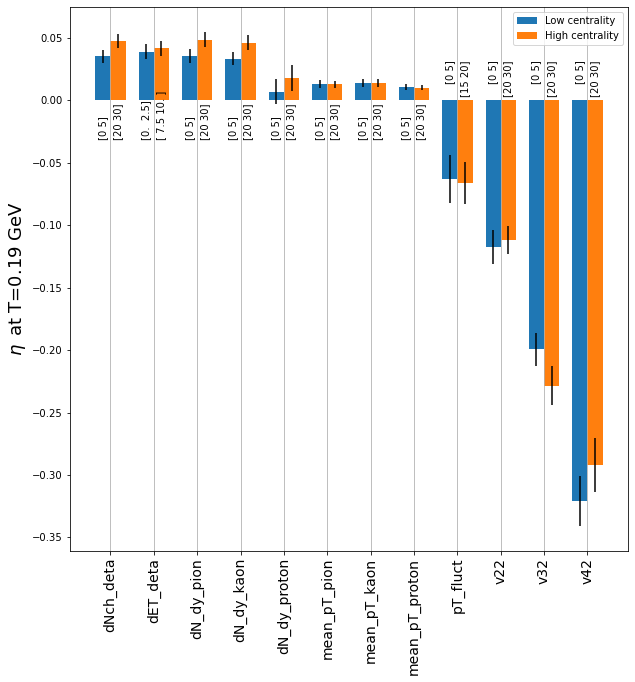

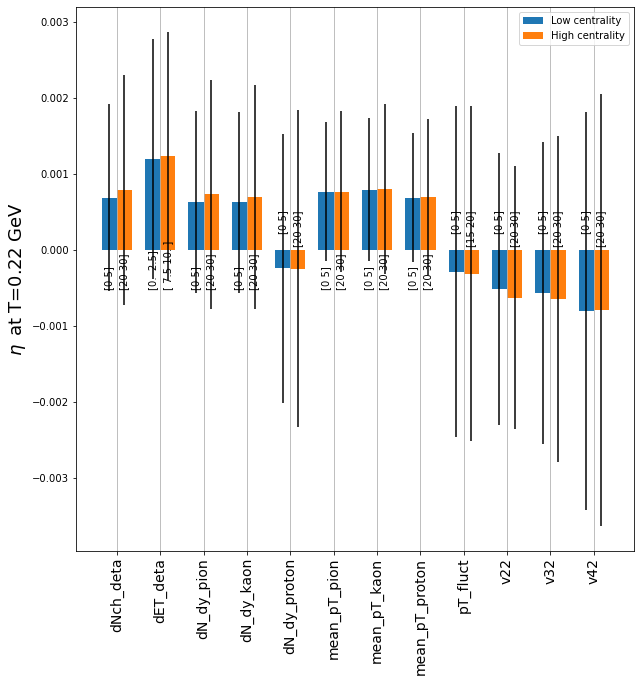

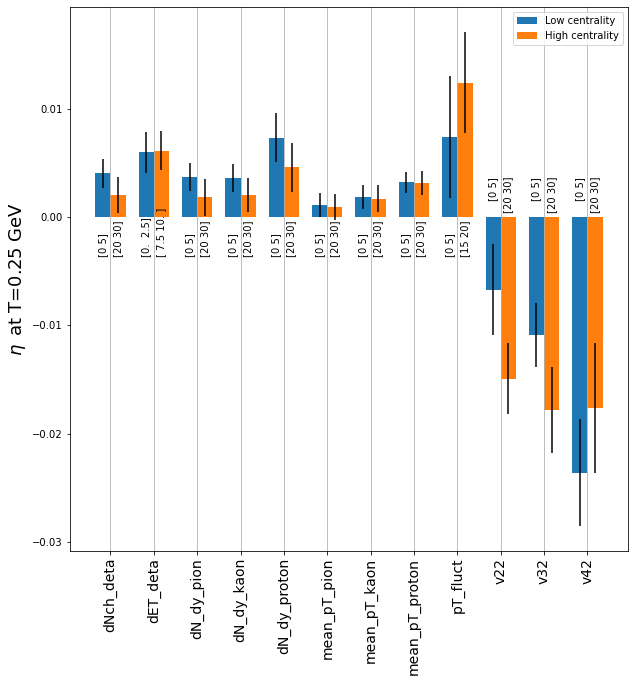

In [55]:
for i in range(11,14):
    sensitivity_plot_scott_grouped_with_error(40,i)

In [56]:
#PCAgraphnt(0,GPy_emulators)

In [57]:
#PCAgraphnt(0,GPy_emulators)

In [58]:
#x_star=np.random.uniform(design_min,design_max)

In [59]:
np.array(MAP_params["Pb-Pb-2760"])

array([14.128,  0.089,  1.054,  1.064,  4.227,  1.507,  0.113,  0.223,
       -1.585,  0.32 ,  0.056,  0.11 ,  0.16 ,  0.093, -0.084,  4.666,
        0.136])